#### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.graph_objects as go

from scipy.stats import zscore


#### 2. Load Datasets (csv's)

In [2]:
customers       = pd.read_csv("Datasets\Customers.csv", 
                              encoding="latin1")

exchange_rates  = pd.read_csv("Datasets\Exchange_Rates.csv", 
                              encoding="latin1")

products        = pd.read_csv("Datasets\Products.csv", 
                              encoding="latin1")

sales           = pd.read_csv("Datasets\Sales.csv",
                              encoding="latin1")

stores          = pd.read_csv("Datasets\Stores.csv", 
                              encoding="latin1")


#### 3. Explore Data

##### 3.1. Customers

In [3]:
customers.head()

,CustomerKey,Gender,Name,City,State Code,State,Zip Code,Country,Continent,Birthday
0,301,Female,Lilly Harding,WANDEARAH EAST,SA,South Australia,5523,Australia,Australia,7/3/1939
1,325,Female,Madison Hull,MOUNT BUDD,WA,Western Australia,6522,Australia,Australia,9/27/1979
2,554,Female,Claire Ferres,WINJALLOK,VIC,Victoria,3380,Australia,Australia,5/26/1947
3,786,Male,Jai Poltpalingada,MIDDLE RIVER,SA,South Australia,5223,Australia,Australia,9/17/1957
4,1042,Male,Aidan Pankhurst,TAWONGA SOUTH,VIC,Victoria,3698,Australia,Australia,11/19/1965


In [4]:
# Check columns and data types
customers.info()

# Cleanup: Convert object birthday to date type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15266 entries, 0 to 15265
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CustomerKey  15266 non-null  int64 
 1   Gender       15266 non-null  object
 2   Name         15266 non-null  object
 3   City         15266 non-null  object
 4   State Code   15256 non-null  object
 5   State        15266 non-null  object
 6   Zip Code     15266 non-null  object
 7   Country      15266 non-null  object
 8   Continent    15266 non-null  object
 9   Birthday     15266 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.2+ MB


In [5]:
# Check for null values in customers
customers.isnull().sum()

# Cleanup: State code has 10 null values. Replace these missing values with their codes based on state names of existing data

CustomerKey     0
Gender          0
Name            0
City            0
State Code     10
State           0
Zip Code        0
Country         0
Continent       0
Birthday        0
dtype: int64

In [6]:
# Check for duplicates = no duplicate rows
duplicates = customers.duplicated()

duplicates.sum()

0

In [7]:
# Check that customer keys are unique = 15266 unique keys = correct
customers["CustomerKey"].is_unique

True

In [8]:
# Check for outliers = no measurable columns so no outliers to detect

##### 3.2. Sales

In [9]:
sales.head()

,Order Number,Line Item,Order Date,Delivery Date,CustomerKey,StoreKey,ProductKey,Quantity,Currency Code
0,366000,1,1/1/2016,NaN,265598,10,1304,1,CAD
1,366001,1,1/1/2016,1/13/2016,1269051,0,1048,2,USD
2,366001,2,1/1/2016,1/13/2016,1269051,0,2007,1,USD
3,366002,1,1/1/2016,1/12/2016,266019,0,1106,7,CAD
4,366002,2,1/1/2016,1/12/2016,266019,0,373,1,CAD


In [10]:
sales.info()

# Convert objects order date and delivery date to date type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62884 entries, 0 to 62883
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Order Number   62884 non-null  int64 
 1   Line Item      62884 non-null  int64 
 2   Order Date     62884 non-null  object
 3   Delivery Date  13165 non-null  object
 4   CustomerKey    62884 non-null  int64 
 5   StoreKey       62884 non-null  int64 
 6   ProductKey     62884 non-null  int64 
 7   Quantity       62884 non-null  int64 
 8   Currency Code  62884 non-null  object
dtypes: int64(6), object(3)
memory usage: 4.3+ MB


In [11]:
# Check for null values in sales
sales.isnull().sum()

# Cleanup: Delivery Date has 49719 null values. Wont be good to exclude all these dates as it forms the majority of the dataset
# Find average delivery date based on existing order and delivery dates

Order Number         0
Line Item            0
Order Date           0
Delivery Date    49719
CustomerKey          0
StoreKey             0
ProductKey           0
Quantity             0
Currency Code        0
dtype: int64

In [12]:
# Check for duplicates = no duplicate rows
duplicates = sales.duplicated()

duplicates.sum()

0

In [13]:
# Check for unique order number and line item combo/ duplicate order number- line item combo = no duplicates
sales.duplicated(subset=['Order Number', 'Line Item']).sum()

0

##### Outliers: Quantity


In [14]:
# Check for outliers in Quantity column

# Data distribution
sales['Quantity'].describe()

count    62884.000000
mean         3.144790
std          2.256371
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         10.000000
Name: Quantity, dtype: float64

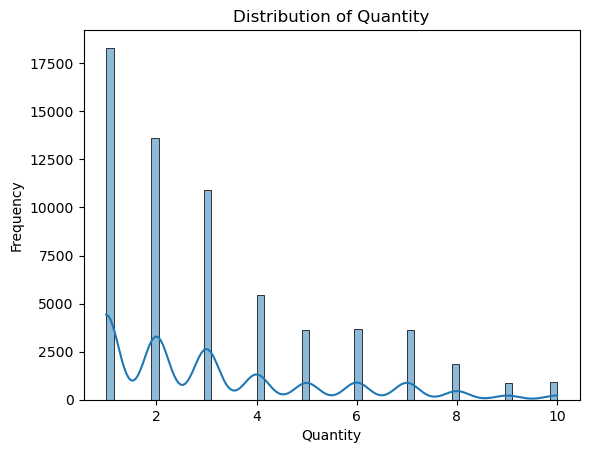

In [15]:
# Check data distribution via histogram = skewed to the right
sns.histplot(sales['Quantity'], kde=True)
plt.title("Distribution of Quantity")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.show()

In [16]:
# Check data distribution via skewness calculation = 1.12 = right/ positive skew
sales['Quantity'].skew()

# Interpretation:
# 0 = perfectly symmetrical (normal)

# 0 to ±0.5 = roughly symmetrical

# > +0.5 = right-skewed (positive skew)

# < -0.5 = left-skewed (negative skew)

1.1149793363443923

In [17]:
# Use IQR to check for outliers since it doesn't rely on normal distribution
# There are 1808 outliers for quantity
Q1 = sales['Quantity'].quantile(0.25)
Q3 = sales['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers
outliers = sales[(sales['Quantity'] < lower_bound) | (sales['Quantity'] > upper_bound)]

print("Number of outliers:", len(outliers))


Number of outliers: 1808


In [18]:
# Let assess the outliers further to decide how to treat them = no treatment
outliers.sort_values(by= "Quantity", ascending=False)

# 9 and 10 units per order is common for some products (e.g., bulk purchases), won't treat it as an outlier for those products. 
# In this case, a max of 10 is reasonable and not necessarily an data entry error.


,Order Number,Line Item,Order Date,Delivery Date,CustomerKey,StoreKey,ProductKey,Quantity,Currency Code
31152,1492016,5,1/31/2019,NaN,1281023,57,1807,10,USD
26350,1428000,2,11/28/2018,NaN,790269,29,1816,10,EUR
49672,1819051,1,12/24/2019,12/31/2019,323542,0,1613,10,CAD
25444,1408024,1,11/8/2018,11/14/2018,1604428,0,1589,10,USD
49636,1819035,5,12/24/2019,NaN,1724829,47,1623,10,USD
...,...,...,...,...,...,...,...,...,...
28404,1456068,1,12/26/2018,NaN,1878787,57,2507,9,USD
28286,1456010,3,12/26/2018,NaN,809243,34,73,9,EUR
28254,1455052,2,12/25/2018,NaN,490850,20,428,9,EUR
28125,1454030,1,12/24/2018,NaN,1281061,54,1637,9,USD


##### 3.3. Exchange Rates

In [19]:
exchange_rates.head()

,Date,Currency,Exchange
0,1/1/2015,USD,1.0000
1,1/1/2015,CAD,1.1583
2,1/1/2015,AUD,1.2214
3,1/1/2015,EUR,0.8237
4,1/1/2015,GBP,0.6415


In [20]:
exchange_rates.info()

# Convert object date to date type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11215 entries, 0 to 11214
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      11215 non-null  object 
 1   Currency  11215 non-null  object 
 2   Exchange  11215 non-null  float64
dtypes: float64(1), object(2)
memory usage: 263.0+ KB


In [21]:
# Check exchange rate for null values
exchange_rates.isnull().sum()

# No null values

Date        0
Currency    0
Exchange    0
dtype: int64

In [22]:
# Duplicate rows = no duplicates
exchange_rates.duplicated().sum()

0

In [23]:
# No unique values

###### Outliers: Exchange Rate

In [24]:
# Check stats
exchange_rates['Exchange'].describe()

# These numbers are typical of real-world exchange rates between major currencies (e.g., EUR/USD, GBP/USD, CAD/EUR). 
# Most float between 0.6 and 1.7, which is entirely realistic.
# No values are obviously erroneous (e.g., no 0s, 10s, or 100s).
# The distribution appears mildly right-skewed, but within reason — 
# possibly due to weaker currencies (e.g., ZAR, INR) being compared against stronger ones (e.g., USD, EUR).
# The standard deviation is low relative to the mean (~23%), suggesting no major volatility spikes.



count    11215.000000
mean         1.061682
std          0.245519
min          0.628500
25%          0.857800
50%          1.000000
75%          1.311900
max          1.725300
Name: Exchange, dtype: float64

In [25]:
# Outlier detection = no outliers
Q1 = exchange_rates['Exchange'].quantile(0.25)
Q3 = exchange_rates['Exchange'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Prints exchange rates that are below the lower bound or above the upper bound
outliers = exchange_rates[(exchange_rates['Exchange'] < lower_bound) | (exchange_rates['Exchange'] > upper_bound)]
print(outliers)


Empty DataFrame
Columns: [Date, Currency, Exchange]
Index: []


##### 3.4. Products

In [26]:
products.head()

,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
0,1,Contoso 512MB MP3 Player E51 Silver,Contoso,Silver,$6.62,$12.99,101,MP4&MP3,1,Audio
1,2,Contoso 512MB MP3 Player E51 Blue,Contoso,Blue,$6.62,$12.99,101,MP4&MP3,1,Audio
2,3,Contoso 1G MP3 Player E100 White,Contoso,White,$7.40,$14.52,101,MP4&MP3,1,Audio
3,4,Contoso 2G MP3 Player E200 Silver,Contoso,Silver,$11.00,$21.57,101,MP4&MP3,1,Audio
4,5,Contoso 2G MP3 Player E200 Red,Contoso,Red,$11.00,$21.57,101,MP4&MP3,1,Audio


In [27]:
products.info()

# Remove the dollar symbol from objects unit cost usd and unit price usd and convert to float type 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ProductKey      2517 non-null   int64 
 1   Product Name    2517 non-null   object
 2   Brand           2517 non-null   object
 3   Color           2517 non-null   object
 4   Unit Cost USD   2517 non-null   object
 5   Unit Price USD  2517 non-null   object
 6   SubcategoryKey  2517 non-null   int64 
 7   Subcategory     2517 non-null   object
 8   CategoryKey     2517 non-null   int64 
 9   Category        2517 non-null   object
dtypes: int64(3), object(7)
memory usage: 196.8+ KB


In [28]:
# Check products for null values
products.isnull().sum()

# No null values

ProductKey        0
Product Name      0
Brand             0
Color             0
Unit Cost USD     0
Unit Price USD    0
SubcategoryKey    0
Subcategory       0
CategoryKey       0
Category          0
dtype: int64

In [29]:
# Check unique product key = True
products['ProductKey'].is_unique

True

In [30]:
# Check if product name is unique = True
products['Product Name'].is_unique

True

In [31]:
# Check for duplicate rows = no duplicate rows
products.duplicated().sum()

0

###### Outliers: Unit Cost and Unit Price

###### Unit Cost

In [32]:
# Remove the dollar symbol and commas from objects unit cost usd and unit price usd and convert to float type

products["Unit Cost USD"]   = products["Unit Cost USD"].str.replace("$", "").str.replace(",", "").astype("float")

products["Unit Price USD"]  = products["Unit Price USD"].str.replace("$", "").str.replace(",","").astype("float")

In [33]:
# All categories
products.value_counts('Category')

Category
Home Appliances                  661
Computers                        606
Cameras and camcorders           372
Cell phones                      285
TV and Video                     222
Games and Toys                   166
Audio                            115
Music, Movies and Audio Books     90
Name: count, dtype: int64

In [34]:
# Stats for each category
products.groupby('Category')['Unit Cost USD'].describe()

# Home Appliances
# Outliers: This category could include expensive appliances like refrigerators, washers, or dryers.
# Treatment: No action needed. The maximum value is reasonable for high-end or luxury appliances. 
# Leave the outliers as they are. No data entry issues.

# Computers
# Outliers: This category can include high-end computers like gaming laptops or workstations, which can be expensive.
# Treatment: No action needed. The maximum value appears to be reasonable for premium or professional computers. 
# You could verify the nature of these items, but generally, no change is required.

# Cameras and Camcorders
# Outliers: Prices up to 536.74 USD are typical for high-end cameras.
# Treatment: No action needed. The outliers are likely legitimate high-end products. 
# You can leave them as they are, but it would be beneficial to document that they represent premium or professional-grade items.

# TV & Video
# Outliers: This category includes high-end televisions and video equipment, so the prices up to 960.82 are reasonable.
# Treatment: No action needed. The outliers are likely valid and represent high-end products. 
# Verify the nature of the products if needed, but generally, no action is required.

# Games & Toys (have high outliers so will assess them)

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Audio,115.0,57.105826,29.877593,6.62,34.3600,52.880,83.2400,106.69
Cameras and camcorders,372.0,158.695000,125.315148,3.54,76.5300,142.365,209.0300,536.74
Cell phones,285.0,75.821789,57.678976,1.50,13.3300,95.650,128.7600,195.15
Computers,606.0,134.133432,162.597745,0.48,26.9700,72.560,195.2400,827.97
Games and Toys,166.0,19.284096,18.125208,2.54,5.6000,16.310,28.5375,198.39
Home Appliances,661.0,225.568714,265.213019,2.54,61.1700,123.470,220.6400,1060.22
"Music, Movies and Audio Books",90.0,42.109333,33.503483,5.09,7.5800,27.130,73.5700,96.08
TV and Video,222.0,211.988063,148.048379,29.01,133.3225,176.590,266.2600,960.82


In [35]:
# Identifying outliers in Games and Toys category
games_and_toys = products[products['Category'] == 'Games and Toys']
q1 = games_and_toys['Unit Cost USD'].quantile(0.25)
q3 = games_and_toys['Unit Cost USD'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Set display option to show more characters in string columns
pd.set_option('display.max_colwidth', None)

outliers_games_and_toys = games_and_toys[(games_and_toys['Unit Cost USD'] < lower_bound) | (games_and_toys['Unit Cost USD'] > upper_bound)]
outliers_games_and_toys[['Product Name', 'Unit Cost USD', 'Subcategory']]

# Price Range of Downloadable Games: Download games typically range from $5 to $50 USD (depending on the type of game and platform). 
# Prices for premium games or special editions could go higher, 
# but $198.39 seems unusually high for a standard downloadable game, which may suggest an error or anomaly in the data.
# Compare with Median: You found that the median price for the "Download Games" subcategory is $21.92. 
# This suggests that most games in this category fall within a much lower price range, making $198.39 an outlier.
# Treatment: Will replace the value with a median price for download games

,Product Name,Unit Cost USD,Subcategory
1764,MGS Age of Empires Expansion: The Rise of Rome X900,198.39,Download Games


In [36]:
# Check all download games
products[(products['Subcategory'] == 'Download Games') & (products['Unit Cost USD'] == 198.39)]

,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
1764,1765,MGS Age of Empires Expansion: The Rise of Rome X900,Tailspin Toys,Blue,198.39,598.8,702,Download Games,7,Games and Toys


In [37]:
# Outlier Treatment

# Filter the data for "Download Games"
d_games = products[products['Subcategory'] == 'Download Games']
d_games


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
1706,1707,MGS Dal of Honor Airborne M150,Tailspin Toys,Silver,32.25,70.13,702,Download Games,7,Games and Toys
1707,1708,MGS Collector's M160,Tailspin Toys,Black,32.25,70.13,702,Download Games,7,Games and Toys
1708,1709,MGS Gears of War M170,Tailspin Toys,Blue,32.25,70.13,702,Download Games,7,Games and Toys
1709,1710,MGS Age of Empires III: The Asian Dynasties M180,Tailspin Toys,Silver,32.25,70.13,702,Download Games,7,Games and Toys
1710,1711,MGS Age of Empires III: The Asian Dynasties M190,Tailspin Toys,Black,32.25,70.13,702,Download Games,7,Games and Toys
...,...,...,...,...,...,...,...,...,...,...
1821,1822,MGS Age of Empires II: The Conquerors Expansion 2009 E178,Tailspin Toys,Blue,16.31,32.00,702,Download Games,7,Games and Toys
1822,1823,MGS Flight Simulator 2009 E179,Tailspin Toys,Blue,16.31,32.00,702,Download Games,7,Games and Toys
1823,1824,MGS Age of Empires II: The Age of Kings 2009 E180,Tailspin Toys,Blue,16.31,32.00,702,Download Games,7,Games and Toys
1824,1825,MGS Age of Empires Expansion: The Rise of Rome 2009 E181,Tailspin Toys,Blue,16.31,32.00,702,Download Games,7,Games and Toys


In [38]:
# Filter for Download Games
products[products['Subcategory'] == 'Download Games']

# Find the median of the "Unit Cost USD" for Download Games = 21.92
median_cost = d_games['Unit Cost USD'].median()

# Loop through each row in the DataFrame and replace outlier with median if condition met
for index, row in products.iterrows():
    if row['Subcategory'] == 'Download Games' and row['Unit Cost USD'] == 198.39:
        products.at[index, 'Unit Cost USD'] = median_cost

# Verify the change = Yes, new unit cost is $21.92
products[products['Product Name'] == 'MGS Age of Empires Expansion: The Rise of Rome X900']


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
1764,1765,MGS Age of Empires Expansion: The Rise of Rome X900,Tailspin Toys,Blue,21.92,598.8,702,Download Games,7,Games and Toys


###### Outliers: Unit Price

In [39]:
# Get stats based on category for more accuracy
products.groupby('Category')['Unit Price USD'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Audio,115.0,135.879043,82.668453,12.99,67.400,132.99,199.9000,299.23
Cameras and camcorders,372.0,400.321774,355.881839,6.95,176.000,308.00,573.0000,1620.00
Cell phones,285.0,174.871404,140.044308,2.94,28.990,208.00,289.0000,589.00
Computers,606.0,331.702310,462.859326,0.95,53.425,161.50,382.9875,2499.00
Games and Toys,166.0,42.532108,51.554540,4.98,16.890,32.00,56.0000,598.80
Home Appliances,661.0,537.802738,698.262706,4.99,119.990,268.50,635.9900,3199.99
"Music, Movies and Audio Books",90.0,108.146000,96.421936,9.99,17.990,58.99,179.9900,289.99
TV and Video,222.0,497.588378,446.047079,56.90,269.225,364.50,599.0000,2899.99


###### Audio


In [40]:
# Assess the category stats that need outlier detection
# Since this is not a normal distribution I will use IQR method

# Audio Distribution = 0.39 = slightly right skewed but close to normal
audio = products[products["Category"] == "Audio"]
skew = audio["Unit Price USD"].skew()
print(f"Skewness = {skew}")
print("Therefore, to be more robust, I will use the IQR method.")
print()

#IQR = 132.5
Q1 = 67.400
Q3 = 199.9000
IQR = Q3 - Q1
print(f"IQR = {IQR}")

# Upper Bound = 398.65
upper = Q3 + 1.5 * IQR
print(f"Upper Bound = {upper}")

# Lower Bound = -131.35
lower = Q1 - 1.5 * IQR
print(f"Lower bound = {lower}")

# Filter for outliers = no outliers
audio[(audio["Unit Price USD"] < lower) | (audio["Unit Price USD"] > upper)]



Skewness = 0.3908742195817942
Therefore, to be more robust, I will use the IQR method.

IQR = 132.5
Upper Bound = 398.65
Lower bound = -131.35


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category


###### Cameras and Camcorders

In [41]:
# Cameras Distribution Skew = 1.63 = highly positively skewed
cameras = products[products["Category"] == "Cameras and camcorders"]
skew = cameras["Unit Price USD"].skew()
print(f"Skewness = {skew}")
print()

# Calculate IQR = 397
Q1 = 176
Q3 = 573
IQR = Q3 - Q1

print(f"IQR = {IQR}")

# Lower Bound = -419.5
lower = Q1 - 1.5 * IQR
print(f"Lower bound = {lower}")

# Upper Bound = 595.5
upper = Q3 = 1.5 * IQR
print(f"Upper bound = {upper}")

# Filter for the Upper Outliers
cam_outliers = cameras[(cameras["Unit Price USD"] < lower) | (cameras["Unit Price USD"] > upper)]
cam_outliers.sort_values(by="Unit Price USD", ascending=False)

Skewness = 1.6333240063764984

IQR = 397
Lower bound = -419.5
Upper bound = 595.5


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
1227,1228,"Fabrikam Independent Filmmaker 1"" 25mm X400 Blue",Fabrikam,Blue,536.74,1620.0,405,Camcorders,4,Cameras and camcorders
1203,1204,Fabrikam Independent Filmmaker 1'' 25mm X400 Grey,Fabrikam,Grey,530.11,1600.0,405,Camcorders,4,Cameras and camcorders
1155,1156,Fabrikam Independent Filmmaker 1'' 25mm X400 Black,Fabrikam,Black,530.11,1600.0,405,Camcorders,4,Cameras and camcorders
1179,1180,Fabrikam Independent filmmaker 1'' 25mm X400 White,Fabrikam,White,530.11,1600.0,405,Camcorders,4,Cameras and camcorders
1180,1181,Fabrikam Independent filmmaker 1/2'' 3mm X300 White,Fabrikam,White,523.49,1580.0,405,Camcorders,4,Cameras and camcorders
...,...,...,...,...,...,...,...,...,...,...
1131,1132,Fabrikam SLR Camera X149 Blue,Fabrikam,Blue,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders
1215,1216,Fabrikam Home and Vacation Moviemaker 1'' 25mm M400 Black,Fabrikam,Black,285.12,620.0,405,Camcorders,4,Cameras and camcorders
1191,1192,Fabrikam Home and Vacation Moviemaker 1'' 25mm M400 Grey,Fabrikam,Grey,275.92,600.0,405,Camcorders,4,Cameras and camcorders
1143,1144,"Fabrikam Home and Vacation Moviemaker 1"" 25mm M400 Blue",Fabrikam,Blue,275.92,600.0,405,Camcorders,4,Cameras and camcorders


In [42]:
# Asessing Cameras and Camcorders Outliers
# Brand Name Counts
outlier_cam_count = cam_outliers["Brand"].value_counts()

# All camera brand counts
normal_cam_count = cameras.value_counts("Brand")

print(f"All Cameras: {normal_cam_count}")

print()
print(f"Outlier Cameras: {outlier_cam_count}")

# It is determined that These are luxury brand cameras so the outliers for Fabrikan will have to be calculated based on the brand name alone
# As for the other 2, I will examine them manually to determine how to treat them. Will probably be seen as entry errors


All Cameras: Brand
Fabrikam    139
A. Datum    132
Contoso     101
Name: count, dtype: int64

Outlier Cameras: Brand
Fabrikam    70
Contoso      7
A. Datum     5
Name: count, dtype: int64


In [43]:
# Examining Contoso Outliers
contoso_outliers = cam_outliers[cam_outliers["Brand"] == "Contoso"]

print("Contoso outliers table:")
contoso_outliers

# Stakeholders were consulted to determine whether or not the 7 Contoso Camera Outliers were data entry mistakes or accurate prices and they were accurate

Contoso outliers table:


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
1075,1076,Contoso SLR Camera X142 Black,Contoso,Black,211.05,637.0,402,Digital SLR Cameras,4,Cameras and camcorders
1079,1080,Contoso SLR Camera X143 Silver,Contoso,Silver,214.03,646.0,402,Digital SLR Cameras,4,Cameras and camcorders
1083,1084,Contoso SLR Camera X143 Grey,Contoso,Grey,214.03,646.0,402,Digital SLR Cameras,4,Cameras and camcorders
1087,1088,Contoso SLR Camera X144 Silver Grey,Contoso,Silver Grey,222.98,673.0,402,Digital SLR Cameras,4,Cameras and camcorders
1091,1092,Contoso SLR Camera X144 Gold,Contoso,Gold,222.98,673.0,402,Digital SLR Cameras,4,Cameras and camcorders
1095,1096,Contoso SLR Camera X145 Pink,Contoso,Pink,209.39,632.0,402,Digital SLR Cameras,4,Cameras and camcorders
1099,1100,Contoso SLR Camera X145 Blue,Contoso,Blue,209.39,632.0,402,Digital SLR Cameras,4,Cameras and camcorders


In [44]:
# Filter for only Contoso Cameras
contoso_cameras_all = products[(products["Brand"] == "Contoso") & (products["Category"] == "Cameras and camcorders")].sort_values(by="Unit Price USD", ascending=False)

# Distribution type for Contoso Cameras skewness = 0.85 which is right-skewed
skew = contoso_cameras_all['Unit Price USD'].skew()
print(f"Skewness = {skew}")


Skewness = 0.8474367205630143


In [45]:
# Use IQR Method to find brand-specific outliers for Contoso cameras
Q1 = contoso_cameras_all["Unit Price USD"].quantile(0.25)
Q3 = contoso_cameras_all["Unit Price USD"].quantile(0.75)
IQR = Q3 - Q1

print(f"IQR = {IQR}")
print()

# Lower Bound
lower = Q1 - 1.5 * IQR
print(f"Lower bound = {lower}")

# Upper Bound
upper = Q3 + 1.5 * IQR
print(f"Upper bound = {upper}")
print()

# Are there any outliers?
print(f"There are no outliers for Contoso cameras")

# Filter for outliers
contoso_cameras_all[(contoso_cameras_all["Unit Price USD"] < lower) | (contoso_cameras_all["Unit Price USD"] > upper)]


IQR = 321.01

Lower bound = -444.525
Upper bound = 839.515

There are no outliers for Contoso cameras


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category


In [46]:
# Filter for A. Datum camera brand
adatum = cameras[cameras["Brand"] == "A. Datum"]

# Analysing A. Datum Cameras
skew = adatum["Unit Price USD"].skew()
print(f"Skewness = {skew}")
print("Therefore the data distribution is right-skewed and IQR method will be applied.")

# IQR
Q1 = adatum["Unit Price USD"].quantile(0.25)
Q3 = adatum["Unit Price USD"].quantile(0.75)
IQR = Q3 - Q1

print()
print(f"IQR = {IQR}")

# Lower Bound
lower = Q1 - 1.5 * IQR
print(f"Lower Bound = {lower}")

# Upper Bound
upper = Q3 + 1.5 * IQR
print(f"Upper Bound = {upper}")
print()

# Filter for outliers
adatum_cameras_outliers = adatum[(adatum["Unit Price USD"] < lower) | (adatum["Unit Price USD"] > upper)]
adatum_cameras_outliers


Skewness = 1.7007383399091327
Therefore the data distribution is right-skewed and IQR method will be applied.

IQR = 103.1
Lower Bound = 32.25000000000003
Upper Bound = 444.65



,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
1043,1044,A. Datum SLR Camera X135 Black,A. Datum,Black,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders
1044,1045,"A. Datum SLR Camera 35"" X358 Black",A. Datum,Black,194.82,588.0,402,Digital SLR Cameras,4,Cameras and camcorders
1048,1049,"A. Datum SLR Camera 35"" X358 Silver",A. Datum,Silver,194.82,588.0,402,Digital SLR Cameras,4,Cameras and camcorders
1051,1052,A. Datum SLR Camera X137 Grey,A. Datum,Grey,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders
1052,1053,"A. Datum SLR Camera 35"" X358 Grey",A. Datum,Grey,194.82,588.0,402,Digital SLR Cameras,4,Cameras and camcorders
1055,1056,A. Datum SLR Camera X138 Silver Grey,A. Datum,Silver Grey,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders
1056,1057,"A. Datum SLR Camera 35"" X358 Silver Grey",A. Datum,Silver Grey,194.82,588.0,402,Digital SLR Cameras,4,Cameras and camcorders
1059,1060,A. Datum SLR Camera X139 Gold,A. Datum,Gold,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders
1060,1061,"A. Datum SLR Camera 35"" X358 Gold",A. Datum,Gold,194.82,588.0,402,Digital SLR Cameras,4,Cameras and camcorders
1063,1064,A. Datum SLR Camera X140 Pink,A. Datum,Pink,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders


In [47]:
# Treatment
print("After consulting the stakeholders to find out if these Unit Prices are accurate,")
print("it was discovered that x358 versions of A. Datum cameras have more advanced and professional features.")
print("For the $627.0 cameras, these 5 models of camera were all special edition camras whose prices were reflected accurately.")
print("and the stakeholder advised me to keep all values within the dataset to reflect accuracy")

# Investigating the upper outliers for A Datum Cameras by filtering for the outliers
adatum_cameras_outliers.sort_values(by="Unit Price USD", ascending=False)


After consulting the stakeholders to find out if these Unit Prices are accurate,
it was discovered that x358 versions of A. Datum cameras have more advanced and professional features.
For the $627.0 cameras, these 5 models of camera were all special edition camras whose prices were reflected accurately.
and the stakeholder advised me to keep all values within the dataset to reflect accuracy


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
1043,1044,A. Datum SLR Camera X135 Black,A. Datum,Black,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders
1051,1052,A. Datum SLR Camera X137 Grey,A. Datum,Grey,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders
1055,1056,A. Datum SLR Camera X138 Silver Grey,A. Datum,Silver Grey,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders
1059,1060,A. Datum SLR Camera X139 Gold,A. Datum,Gold,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders
1063,1064,A. Datum SLR Camera X140 Pink,A. Datum,Pink,207.74,627.0,402,Digital SLR Cameras,4,Cameras and camcorders
1044,1045,"A. Datum SLR Camera 35"" X358 Black",A. Datum,Black,194.82,588.0,402,Digital SLR Cameras,4,Cameras and camcorders
1048,1049,"A. Datum SLR Camera 35"" X358 Silver",A. Datum,Silver,194.82,588.0,402,Digital SLR Cameras,4,Cameras and camcorders
1052,1053,"A. Datum SLR Camera 35"" X358 Grey",A. Datum,Grey,194.82,588.0,402,Digital SLR Cameras,4,Cameras and camcorders
1056,1057,"A. Datum SLR Camera 35"" X358 Silver Grey",A. Datum,Silver Grey,194.82,588.0,402,Digital SLR Cameras,4,Cameras and camcorders
1060,1061,"A. Datum SLR Camera 35"" X358 Gold",A. Datum,Gold,194.82,588.0,402,Digital SLR Cameras,4,Cameras and camcorders


In [48]:
# Assessing Fabrikam Cameras 
fabrikam_cameras = products[(products["Brand"] == "Fabrikam") & (products["Category"] == "Cameras and camcorders")]

# Data Distribution = 0.89
skew = fabrikam_cameras["Unit Price USD"].skew()
print(f"Skewness = {skew}")
print("Therefore, this is a right-skewed distribution and IQR method will apply.")

# Calculate IQR
Q1 = fabrikam_cameras["Unit Price USD"].quantile(0.25)
Q3 = fabrikam_cameras["Unit Price USD"].quantile(0.75)
IQR = Q3 - Q1

print()
print(f"IQR = {IQR}")

# Lower Bound
lower = Q1 - 1.5 * IQR
print(f"Lower Bound = {lower}")

# Upper Bound
upper = Q3 + 1.5 * IQR
print(f"Upper Bound = {upper}")

# Treatment
print("There are no outliers, therefore, no treatment to be applied.")
fabrikam_cameras[(fabrikam_cameras["Unit Price USD"] < lower ) | (fabrikam_cameras["Unit Price USD"] > upper)]


Skewness = 0.8899059795007996
Therefore, this is a right-skewed distribution and IQR method will apply.

IQR = 555.0
Lower Bound = -498.5
Upper Bound = 1721.5
There are no outliers, therefore, no treatment to be applied.


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category


In [49]:
# Cellphones
cellphones = products[products["Category"] == "Cell phones"]

# Skewness = 0.31
skew = cellphones["Unit Price USD"].skew()
print(f"Skewness = {skew}")
print("Therefore, the data is slightly positive-skewed. So use IQR method.")
print()

# IQR
Q1 = cellphones["Unit Price USD"].quantile(0.25)
Q3 = cellphones["Unit Price USD"].quantile(0.75)
IQR = Q3 - Q1

# Lower Bound
lower = Q1 - 1.5 * IQR
print(f"Lower Bound = {lower}")

# Upper Bound
upper = Q3 + 1.5 * IQR
print(f"Upper Bound = {upper}")
print()

# Treatment
print("Treatment:")
print(f"There are no outliers for cellphones.")

# Filter for outliers
cellphones[(cellphones["Unit Price USD"] < lower) | (cellphones["Unit Price USD"] > upper)]

Skewness = 0.3058743791986551
Therefore, the data is slightly positive-skewed. So use IQR method.

Lower Bound = -361.025
Upper Bound = 679.015

Treatment:
There are no outliers for cellphones.


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category


In [50]:
# Computers Outlier Detection
computers = products[products["Category"] == "Computers"]

# Skewness = 2.89
skew = computers["Unit Price USD"].skew()
print(f"Skewness = {skew}")
print("Therefore the data is highly skewed to the right. Log + IQR methods will be applied.")

Skewness = 2.8892757459301315
Therefore the data is highly skewed to the right. Log + IQR methods will be applied.


In [51]:
# Make a copy to avoid modifying the original
df = computers.copy()

# Add 1 to avoid log(0)
df['log_price'] = np.log(df['Unit Price USD'] + 1)

# Compute IQR
Q1 = df['log_price'].quantile(0.25)
Q3 = df['log_price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers in log scale
log_outliers = df[(df['log_price'] < lower_bound) | (df['log_price'] > upper_bound)]

# Note
print("Only 4 lower outliers exist within the computers category for the computers Accessories category and these are all the same version of E600 USB Data Cable")

log_outliers

Only 4 lower outliers exist within the computers category for the computers Accessories category and these are all the same version of E600 USB Data Cable


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category,log_price
918,919,SV USB Data Cable E600 Pink,Southridge Video,Pink,0.48,0.95,308,Computers Accessories,3,Computers,0.667829
919,920,SV USB Data Cable E600 Black,Southridge Video,Black,0.48,0.95,308,Computers Accessories,3,Computers,0.667829
920,921,SV USB Data Cable E600 Silver,Southridge Video,Silver,0.48,0.95,308,Computers Accessories,3,Computers,0.667829
921,922,SV USB Data Cable E600 Grey,Southridge Video,Grey,0.48,0.95,308,Computers Accessories,3,Computers,0.667829


In [52]:
# Computer Treatment
print("These 4 items will be kept in the data as this is not a data entry issue. Not unusual for USB cables to cost $0.95. However, it will be noted in the final report")
print("that cheaper accessory items are being lumped in with pricier items like laptops/desktops.")

# Computer Categories
computers["Subcategory"].value_counts()

These 4 items will be kept in the data as this is not a data entry issue. Not unusual for USB cables to cost $0.95. However, it will be noted in the final report
that cheaper accessory items are being lumped in with pricier items like laptops/desktops.


Subcategory
Computers Accessories       201
Projectors & Screens        103
Printers, Scanners & Fax    101
Laptops                      78
Monitors                     78
Desktops                     45
Name: count, dtype: int64

In [53]:
# Games and Toys
games = products[products["Category"] == "Games and Toys"]

# Skewness = 7.77
skew = games["Unit Price USD"].skew()
print(f"Skewnesss = {skew}")
print("Therefore this data is highly/ extremelly right-skewed and I will use the log + IQR method to identify outliers")

# Log 
df = games.copy()
df['log_price'] = np.log(df["Unit Price USD"] + 1)

# Compute IQR
Q1 = df['log_price'].quantile(0.25)
Q3 = df['log_price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers in log scale
log_outliers = df[(df['log_price'] < lower_bound) | (df['log_price'] > upper_bound)]

log_outliers

Skewnesss = 7.773374713362773
Therefore this data is highly/ extremelly right-skewed and I will use the log + IQR method to identify outliers


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category,log_price
1764,1765,MGS Age of Empires Expansion: The Rise of Rome X900,Tailspin Toys,Blue,21.92,598.8,702,Download Games,7,Games and Toys,6.396596


In [54]:
# Games and Toys Treatment
print("Just as I replaced the unit cost with the median cost for Download Games, I will replace the unit price with the median unit price for Download Games.")

# Median
download = products[products["Subcategory"] == "Download Games"]

price_median = download["Unit Price USD"].median()

print(f"Price Median for Download Games = ${price_median}")

# Loop through each row in the DataFrame and replace outlier with median if condition met
for index, row in products.iterrows():
    if row['Subcategory'] == 'Download Games' and row['Unit Price USD'] == 598.8:
        products.at[index, 'Unit Price USD'] = price_median

# Verify the change = Yes, new unit cost is $21.92
products[products['Product Name'] == 'MGS Age of Empires Expansion: The Rise of Rome X900']

Just as I replaced the unit cost with the median cost for Download Games, I will replace the unit price with the median unit price for Download Games.
Price Median for Download Games = $43.0


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
1764,1765,MGS Age of Empires Expansion: The Rise of Rome X900,Tailspin Toys,Blue,21.92,43.0,702,Download Games,7,Games and Toys


In [55]:
# Home Appliances
appliances = products[products["Category"] == "Home Appliances"]

# Skewness = 2.15
skew = appliances["Unit Price USD"].skew()
print(f"Skewness = {skew}")
print("Data is highly right-skewed. Therefore, I will use the Log + IQR method.")

# Log
df = appliances.copy()
df["log_price"] = np.log(df["Unit Price USD"] + 1)

# Compute IQR
Q1 = df['log_price'].quantile(0.25)
Q3 = df['log_price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag outliers in log scale
log_outliers = df[(df['log_price'] < lower_bound) | (df['log_price'] > upper_bound)]

log_outliers

Skewness = 2.15257146761369
Data is highly right-skewed. Therefore, I will use the Log + IQR method.


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category,log_price
2442,2443,Litware 80mm Dual Ball Bearing Case Fan E1001 Black,Litware,Black,2.54,4.99,808,Fans,8,Home Appliances,1.790091
2443,2444,Litware 80mm Dual Ball Bearing Case Fan E1001 White,Litware,White,2.54,4.99,808,Fans,8,Home Appliances,1.790091
2444,2445,Litware 80mm Dual Ball Bearing Case Fan E1001 Green,Litware,Green,2.54,4.99,808,Fans,8,Home Appliances,1.790091
2445,2446,Litware 80mm Dual Ball Bearing Case Fan E1001 Pink,Litware,Pink,2.54,4.99,808,Fans,8,Home Appliances,1.790091


In [56]:
# Treatment 
print("Since the 4 low outliers for Home Appliances are all Fans, I decided to filter for fans and investigate their prices.")
print("It was noted that there are various types of fans ranging from $4.99 to $400.00 but these fans in particular are dual ball bearing case fans.")
print("There is no data entry error when it comes to the Unit Price but case fans are Computer Accessories and not Home Appliances and should be recategorised.")


# Checking Fans in general
appliances[appliances["Subcategory"] == "Fans"].sort_values(by="Unit Price USD",ascending=False)

Since the 4 low outliers for Home Appliances are all Fans, I decided to filter for fans and investigate their prices.
It was noted that there are various types of fans ranging from $4.99 to $400.00 but these fans in particular are dual ball bearing case fans.
There is no data entry error when it comes to the Unit Price but case fans are Computer Accessories and not Home Appliances and should be recategorised.


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
2486,2487,Litware 18'' Oscillating Pedestal Fan M145 White,Litware,White,183.95,400.00,808,Fans,8,Home Appliances
2485,2486,Litware 18'' Oscillating Pedestal Fan M145 Blue,Litware,Blue,183.95,400.00,808,Fans,8,Home Appliances
2484,2485,Litware 18'' Oscillating Pedestal Fan M145 Yellow,Litware,Yellow,183.95,400.00,808,Fans,8,Home Appliances
2483,2484,Litware 18'' Oscillating Pedestal Fan M145 Pink,Litware,Pink,183.95,400.00,808,Fans,8,Home Appliances
2482,2483,Litware 18'' Oscillating Pedestal Fan M135 White,Litware,White,160.95,350.00,808,Fans,8,Home Appliances
...,...,...,...,...,...,...,...,...,...,...
2441,2442,Litware 120mm Blue LED Case Fan E901 Grey,Litware,Grey,5.09,9.99,808,Fans,8,Home Appliances
2443,2444,Litware 80mm Dual Ball Bearing Case Fan E1001 White,Litware,White,2.54,4.99,808,Fans,8,Home Appliances
2444,2445,Litware 80mm Dual Ball Bearing Case Fan E1001 Green,Litware,Green,2.54,4.99,808,Fans,8,Home Appliances
2445,2446,Litware 80mm Dual Ball Bearing Case Fan E1001 Pink,Litware,Pink,2.54,4.99,808,Fans,8,Home Appliances


In [57]:
# Identifying ALL Case Fans Under Home Appliances
case_fans = (
    products['Product Name'].str.contains("case fan", case=False, na=False) &
    (products['Category'] == "Home Appliances")
)

case_fans_to_fix = products[case_fans]

print("This is the list of ALL case fans:")
case_fans_to_fix

This is the list of ALL case fans:


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
2438,2439,Litware 120mm Blue LED Case Fan E901 Black,Litware,Black,5.09,9.99,808,Fans,8,Home Appliances
2439,2440,Litware 120mm Blue LED Case Fan E901 White,Litware,White,5.09,9.99,808,Fans,8,Home Appliances
2440,2441,Litware 120mm Blue LED Case Fan E901 blue,Litware,Blue,5.09,9.99,808,Fans,8,Home Appliances
2441,2442,Litware 120mm Blue LED Case Fan E901 Grey,Litware,Grey,5.09,9.99,808,Fans,8,Home Appliances
2442,2443,Litware 80mm Dual Ball Bearing Case Fan E1001 Black,Litware,Black,2.54,4.99,808,Fans,8,Home Appliances
2443,2444,Litware 80mm Dual Ball Bearing Case Fan E1001 White,Litware,White,2.54,4.99,808,Fans,8,Home Appliances
2444,2445,Litware 80mm Dual Ball Bearing Case Fan E1001 Green,Litware,Green,2.54,4.99,808,Fans,8,Home Appliances
2445,2446,Litware 80mm Dual Ball Bearing Case Fan E1001 Pink,Litware,Pink,2.54,4.99,808,Fans,8,Home Appliances
2446,2447,Litware 92mm DBB Case Fan E1101 Silver,Litware,Silver,7.64,14.99,808,Fans,8,Home Appliances
2447,2448,Litware 92mm DBB Case Fan E1101 Black,Litware,Black,7.64,14.99,808,Fans,8,Home Appliances


In [58]:
# Change case fans to computer accessories
products.loc[case_fans, 'Category'] = "Computers"
products.loc[case_fans, 'Subcategory'] = "Computer Accessories"
products.loc[case_fans, 'SubcategoryKey'] = 308
products.loc[case_fans, 'CategoryKey'] = 3

# Verify the change
products[products['Product Name'].str.contains("case fan", case=False)]


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category
2438,2439,Litware 120mm Blue LED Case Fan E901 Black,Litware,Black,5.09,9.99,308,Computer Accessories,3,Computers
2439,2440,Litware 120mm Blue LED Case Fan E901 White,Litware,White,5.09,9.99,308,Computer Accessories,3,Computers
2440,2441,Litware 120mm Blue LED Case Fan E901 blue,Litware,Blue,5.09,9.99,308,Computer Accessories,3,Computers
2441,2442,Litware 120mm Blue LED Case Fan E901 Grey,Litware,Grey,5.09,9.99,308,Computer Accessories,3,Computers
2442,2443,Litware 80mm Dual Ball Bearing Case Fan E1001 Black,Litware,Black,2.54,4.99,308,Computer Accessories,3,Computers
2443,2444,Litware 80mm Dual Ball Bearing Case Fan E1001 White,Litware,White,2.54,4.99,308,Computer Accessories,3,Computers
2444,2445,Litware 80mm Dual Ball Bearing Case Fan E1001 Green,Litware,Green,2.54,4.99,308,Computer Accessories,3,Computers
2445,2446,Litware 80mm Dual Ball Bearing Case Fan E1001 Pink,Litware,Pink,2.54,4.99,308,Computer Accessories,3,Computers
2446,2447,Litware 92mm DBB Case Fan E1101 Silver,Litware,Silver,7.64,14.99,308,Computer Accessories,3,Computers
2447,2448,Litware 92mm DBB Case Fan E1101 Black,Litware,Black,7.64,14.99,308,Computer Accessories,3,Computers


In [59]:
# Filter for: Music, Movies and Audio Books
music = products[products['Category'] == "Music, Movies and Audio Books"]

# Skewness = 0.59
skew = music["Unit Price USD"].skew()
print(f"Skewness = {skew}")
print("The data distribution is mildly right-skewed. Therefore, I will use the IQR method, although z-score would also be acceptable but IQR is more robust.")

# IQR
Q1 = music["Unit Price USD"].quantile(0.25)
Q3 = music["Unit Price USD"].quantile(0.75)
IQR = Q3 - Q1

print()

# Lower Bound
lower = Q1 - 1.5 * IQR
print(f"Lower Bound = {lower}")

# Upper Bound
upper = Q3 + 1.5 * IQR
print(f"Upper Bound = {upper}")

# Note
print()
print("Note:")
print("There are no outliers so no treatment required.")

# Outliers
music[(music["Unit Price USD"] < lower) | (music["Unit Price USD"] > upper)]

Skewness = 0.5871071512847547
The data distribution is mildly right-skewed. Therefore, I will use the IQR method, although z-score would also be acceptable but IQR is more robust.

Lower Bound = -225.01
Upper Bound = 422.99

Note:
There are no outliers so no treatment required.


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category


In [60]:
# Filter for: TV and Video
tv = products[products["Category"] == "TV and Video"]

# Evaluate Skewness = 3.18
skew = tv["Unit Price USD"].skew()
print(f"Skewness = {skew}")
print("The data is heavily right-skewed. Therefore, I will use the Log + IQR method.")

# Log
df = tv.copy()
df["log_price"] = np.log(df["Unit Price USD"] + 1)

# IQR
Q1 = df["log_price"].quantile(0.25)
Q3 = df["log_price"].quantile(0.75)
IQR = Q3 - Q1

print()

# Lower Bound
lower = Q1 - 1.5 * IQR
print(f"Lower Bound =  {lower}")

# Upper Bound
upper = Q3 + 1.5 * IQR
print(f"Upper Bound = {upper}")

# Isolate the Outliers
df_outliers = df[(df["log_price"] < lower) | (df["log_price"] > upper)].sort_values(by="Unit Price USD", ascending=False)
df_outliers

Skewness = 3.176326876950637
The data is heavily right-skewed. Therefore, I will use the Log + IQR method.

Lower Bound =  4.4027402834796385
Upper Bound = 7.593443278258051


,ProductKey,Product Name,Brand,Color,Unit Cost USD,Unit Price USD,SubcategoryKey,Subcategory,CategoryKey,Category,log_price
144,145,"Adventure Works 52"" LCD HDTV X590 Silver",Adventure Works,Silver,960.82,2899.99,201,Televisions,2,TV and Video,7.972807
145,146,"Adventure Works 52"" LCD HDTV X590 Black",Adventure Works,Black,960.82,2899.99,201,Televisions,2,TV and Video,7.972807
146,147,"Adventure Works 52"" LCD HDTV X590 White",Adventure Works,White,960.82,2899.99,201,Televisions,2,TV and Video,7.972807
147,148,"Adventure Works 52"" LCD HDTV X590 Brown",Adventure Works,Brown,960.82,2899.99,201,Televisions,2,TV and Video,7.972807
166,167,SV 8xDVD E100 Black,Southridge Video,Black,35.18,69.00,202,VCD & DVD,2,TV and Video,4.248495
179,180,SV 8xDVD E100 Silver,Southridge Video,Silver,35.18,69.00,202,VCD & DVD,2,TV and Video,4.248495
177,178,SV 8xDVD E140 Black,Southridge Video,Black,33.65,66.00,202,VCD & DVD,2,TV and Video,4.204693
190,191,SV 8xDVD E140 Silver,Southridge Video,Silver,33.65,66.00,202,VCD & DVD,2,TV and Video,4.204693
176,177,SV 8xDVD E130 Black,Southridge Video,Black,29.01,56.90,202,VCD & DVD,2,TV and Video,4.058717
189,190,SV 8xDVD E130 Silver,Southridge Video,Silver,29.01,56.90,202,VCD & DVD,2,TV and Video,4.058717


In [61]:
# Outlier counts for different subcategories for audio
df_outliers["Subcategory"].value_counts()

Subcategory
VCD & DVD      6
Televisions    4
Name: count, dtype: int64

In [62]:
# Treatment of TV Outliers
print("Because these are valid prices for these sizes of TV's and the DVDs are limited edition box sets and there are no data entry errors here, ") 
print("I will keep these outliers in the dataset to reflect accuracy for unit prices.")
print()
print("I will also mention this in my final report and that DVDs from TV and Video section are lumped in with subcategories like Televisions, under assumptions and caveats section for transparency.")

Because these are valid prices for these sizes of TV's and the DVDs are limited edition box sets and there are no data entry errors here, 
I will keep these outliers in the dataset to reflect accuracy for unit prices.

I will also mention this in my final report and that DVDs from TV and Video section are lumped in with subcategories like Televisions, under assumptions and caveats section for transparency.


##### 3.5. Stores

In [63]:
stores.head()

,StoreKey,Country,State,Square Meters,Open Date
0,1,Australia,Australian Capital Territory,595.0,1/1/2008
1,2,Australia,Northern Territory,665.0,1/12/2008
2,3,Australia,South Australia,2000.0,1/7/2012
3,4,Australia,Tasmania,2000.0,1/1/2010
4,5,Australia,Victoria,2000.0,12/9/2015


In [64]:
stores.info()

# Convert object open date to date type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   StoreKey       67 non-null     int64  
 1   Country        67 non-null     object 
 2   State          67 non-null     object 
 3   Square Meters  66 non-null     float64
 4   Open Date      67 non-null     object 
dtypes: float64(1), int64(1), object(3)
memory usage: 2.7+ KB


In [65]:
# Check stores for null values
stores.isnull().sum()

# Cleanup: Square meters has 1 null value

StoreKey         0
Country          0
State            0
Square Meters    1
Open Date        0
dtype: int64

In [66]:
# Are the Store Keys Unique 
stores["StoreKey"].is_unique

True

In [67]:
# Duplicate Rows = 0
stores.duplicated().sum()

0

In [68]:
# Outliers: Square Meters
skew = stores["Square Meters"].skew()
print(f"Skewness = {skew}")
print("Since the skewness lies close to -0.5. This is slightly left-skewed but I can apply z-score method as it is close to a normal distribution.")

# Note
print()
print("There are no outliers for square meters.")

# Z Score
stores['zscore'] = zscore(stores['Square Meters'])
outliers = stores[(stores['zscore'].abs() > 2.5)]  

outliers

Skewness = -0.5095184502126239
Since the skewness lies close to -0.5. This is slightly left-skewed but I can apply z-score method as it is close to a normal distribution.

There are no outliers for square meters.


,StoreKey,Country,State,Square Meters,Open Date,zscore


#### 4. Cleaning

##### 4.1. Customers

In [69]:
# Convert object birthday to date type
customers.Birthday = pd.to_datetime(customers.Birthday)

In [70]:
# State Code has 10 null values: Replace these missing values with their codes based on state names and codes of existing data

# Step 1: Create a mapping of state_name to state_code from non-missing values, set index to State and set State Code as values, convert to dictionary
state_mapping = customers.dropna(subset=["State Code"]).set_index("State")["State Code"].to_dict()

# Step 2: Fill missing State Code using the mapping
customers["State Code"] = customers["State Code"].fillna(customers["State"].map(state_mapping))


In [71]:
# Since mapping didn't work, check the names of missing value states: All of the missing codes are related to the State of Napoli in Italy
customers[customers["State Code"].isnull()]

# Replace null values with my own code NAP for Napoli. Check if code already exists first
customers[customers["State Code"].str.contains("NAP",na=False)]

# Replacing all null values with NAP
customers["State Code"] = customers["State Code"].fillna("NAP")

##### 4.2. Sales

In [72]:
# Convert objects order date and delivery date to date type
sales["Order Date"]     = pd.to_datetime(sales["Order Date"])

sales["Delivery Date"]  = pd.to_datetime(sales["Delivery Date"])

In [73]:
# Delivery Date has 49719 null values. Find delivery time for each row
sales["Delivery Time"]  = (sales["Delivery Date"] - sales["Order Date"])

# Find the average delivery time based on store: 4 days and 12 hours but only data for StoreKey 0 was available, all other stores had nulls
average_delivery_time   = sales.groupby("StoreKey")["Delivery Time"].mean().dropna()

# Extract the value for number of days from the store key 0
average_days = average_delivery_time.iloc[0]

# Replace missing delivery dates by adding average days to each order date where the delivery date is missing
sales["Delivery Date"] = sales["Delivery Date"].fillna(sales["Order Date"] + average_days)

# Replace missing values for Delivery time(the column I created which will be Nat for missing Delivery Date Values) with the average days
sales["Delivery Time"] = sales["Delivery Time"].fillna(average_days)

In [74]:
# When I got to the end of cleaning up the stores table, I realised only store 0 had delivery dates because its an online store

# Assuming all other stores with locations are physical and that they don't deliver, hence null values, I'll revert the changes to delivery dates
sales.loc[sales["StoreKey"] != 0, "Delivery Date"] = pd.NaT

# Also drop delivery time column that I calculate for physical stores
sales.loc[sales["StoreKey"] != 0, "Delivery Time"] = pd.NaT


##### 4.3. Exchange Rates

In [75]:
# Convert object Date to date type
exchange_rates.Date = pd.to_datetime(exchange_rates.Date)

# No null values

##### 4.4. Products

In [76]:
# Treated unit cost and unit price strings in previous section (removed dollar sign and converted to float)

# No null values

##### 4.5. Stores

In [77]:
# Convert object open date to date type
stores["Open Date"] = pd.to_datetime(stores["Open Date"])

In [78]:
# Cleanup: Square meters has 1 null value
# Check the null value row: through this I discovered StoreKey 0 is missing square meters because its an online store
stores[stores["Square Meters"].isnull()]

# So I replace the null value with a 0 for 0m^2
stores.loc[stores["StoreKey"] == 0, "Square Meters"] = 0


#### 5. Data Manipulation

##### 5.1. Join Tables


In [79]:
# Left Join Customers to Sales
sales_merged = sales.merge(customers, on="CustomerKey", how="left")

# Left Join Products to Sales Merged
sales_merged = sales_merged.merge(products, on="ProductKey", how="left")

# Left Join Stores to Sales Merged
sales_merged = sales_merged.merge(stores, on="StoreKey", how="left")

# Left Join Exchange Rates to Sales Merged
sales_merged = sales_merged.merge(exchange_rates, left_on=["Currency Code", "Order Date"], right_on=["Currency", "Date"], how="left")

##### 5.2. Add Order Month, Order Year, Revenue column, Customer Age column, Store Age column and Store Type column


In [80]:
# Order Month
sales_merged["Order Month"] = sales_merged["Order Date"].dt.strftime('%b')

# Order Year
sales_merged["Order Year"] = sales_merged["Order Date"].dt.year

# Revenue: Multiply Quatity column with Unit Price USD column
sales_merged["Revenue"] = sales_merged["Quantity"] * sales_merged["Unit Price USD"]

# Customer Age: To obtain customer age at the point of order, birth date is subtracted from order date, 
# converted from timedelta to days and divided by a year using floor division to obtain the age in years rounded down
sales_merged["Customer Age"] = (sales_merged["Order Date"] - sales_merged["Birthday"]).dt.days // 365

# Store Age: To obtain store age at the point of order, open date is subtracted from order date,
# converted from timedelta to days and divided by a year using floor division to obtain the age in years rounded down
sales_merged["Store Age"] = (sales_merged["Order Date"] - sales_merged["Open Date"]).dt.days // 365

# Store Type (Online vs Physical)
sales_merged["Store Type"] = sales_merged["Country_y"].apply(lambda x: "Online" if x == "Online" else "Physical")


##### 5.3. Change Column Headings: 
- **State_x** as Customer State
- **State_y** as Store State 
- **Country_x** as Customer Country
- **Country_y** as Store Country 
- **Date** as Exchange Rate Date
- **CustomerKey** as Customer Key
- **StoreKey** as Store Key
- **ProductKey** as Product Key
- **CategoryKey** as Category Key
- **SubcategoryKey** as Subcategory Key
- **Name** to Customer Name
- **City** to Customer City
- **State Code** to Customer State Code
- **Zip Code** to Customer Zip Code
- **Continent** to Customer Continent
- **Birthday** as Customer Birthday
- **Open Date** to Store Open Date
- **Exchange** to Exchange Rate

In [81]:
# Rename Headings
sales_merged = sales_merged.rename(columns={"State_x" : "Customer State", "State_y": "Store State", "Country_x": "Customer Country", "Country_y": "Store Country", 
                                            "Date": "Exchange Rate Date", "CustomerKey": "Customer Key", "StoreKey": "Store Key", "ProductKey": "Product Key", 
                                            "CategoryKey": "Category Key", "SubcategoryKey": "Subcategory Key", "Name": "Customer Name", "City": "Customer City", 
                                            "State Code": "Customer State Code", "Zip Code": "Customer Zip Code", "Continent": "Customer Continent", "Birthday": "Customer Birthday",
                                            "Open Date": "Store Open Date", "Exchange": "Exchange Rate"})

##### 5.4. Remove Duplicate Columns

In [82]:
# Remove the Currency Code column as the information duplicates itself in Currency column
sales_merged.drop(columns=["Currency Code"], inplace=True)

##### 5.5. Rearrange Columns

In [83]:
sales_merged = sales_merged[["Order Number", "Line Item", "Order Date", "Order Month", "Order Year", "Delivery Date", "Delivery Time", "Quantity", "Unit Price USD", "Unit Cost USD", "Revenue", 
                             "Customer Key", "Customer Name", "Gender", "Customer Birthday", "Customer Age", "Customer City", "Customer State", "Customer State Code", 
                             "Customer Zip Code", "Customer Country", "Customer Continent", "Product Key", "Product Name", "Brand", "Color", "Category Key", "Category", 
                             "Subcategory Key", "Subcategory", "Store Key", "Store Country", "Store State", "Square Meters", "Store Open Date", "Store Age", "Store Type", "Currency", 
                             "Exchange Rate Date", "Exchange Rate"]]

#### 6. Aggregation and Visualisation

##### 6.1. Sales Performance & Trends

###### 6.1.1 Revenue By Category Overall (SNS LINEPLOT VERSION)

In [ ]:
#-------------------------------------------------------------------------------------------------------------------------------------
# % Revenue by Category (all 5 years)
#-----------------------------------------------------------------------------------------------------------------------------------
# Adjust figure size
plt.figure(figsize=(30,15))

# Aggregate Revenue Data
revenue_by_category = sales_merged.pivot_table(index="Order Date", columns="Category", values="Revenue", aggfunc="sum")

# Get Monthly level data from order dates for plotting
revenue_by_category = revenue_by_category.resample("ME").sum()

#Adjust figure size
plt.figure(figsize=(30,12))
# Ensure Abbreviated Months are Shown on plot
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Show major tick marks for years
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=1))  # Minor ticks for months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Show Year at major ticks
plt.gca().xaxis.set_minor_formatter(mdates.DateFormatter("%b"))  # Show Month at minor ticks

# Add axv lines to separate years
years = revenue_by_category.index.year.unique()  # Get unique years in the data
for year in years[1:]:  # Skip first year to avoid unnecessary line at start
    year_start = pd.Timestamp(year=year, month=1, day=1)  # Start of each year
    plt.gca().axvline(x=year_start, color="grey", linestyle="dotted", linewidth=1)  # Dotted separator for years

# Plot the Line Graph. Name Lineplot as ax to format axis
ax = sns.lineplot(data=revenue_by_category, dashes=False, palette="husl", linewidth=2)

# Formatting the Chart
#-----------------------
# Increase legend size
legend = ax.legend(fontsize=25, title="Product Category", title_fontsize=30)

# Left-align the legend title
legend._legend_box.align = "left"

# Format y-axis as currency
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))

# Increase Y-axis tick label size
ax.tick_params(axis='y', labelsize=20)

# Ensure Rotation Applies to Both Major(years) & Minor(months) Ticks
ax.tick_params(axis='x', which='major', labelsize=20, rotation=90, pad=20)  # Rotate years
ax.tick_params(axis='x', which='minor', labelsize=16, rotation=90, pad=5)

# Remove the top and right border (spines)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.title("Comparing Revenue Growth by Product Category (2016-2020)", fontsize=45, pad=30)
plt.xlabel("")
plt.show()



###### 6.1.1 Revenue By Category Overall (PLOTLY LINEPLOT VERSION)

In [ ]:
# --------------------------------------------------------------------------
# % Revenue by Category (2016-2020)
# --------------------------------------------------------------------------

# Aggregate Revenue Data Using Pivot Table
revenue_by_category = sales_merged.pivot_table(
    index="Order Date", 
    columns="Category", 
    values="Revenue", 
    aggfunc="sum"
)

# Resample Data to Monthly Level for Smoother Trends
revenue_by_category = revenue_by_category.resample("ME").sum()

# Use the "Greens" Palette from Plotly
greens_palette = px.colors.sequential.Greens  

# --------------------------------------------------------------------------
# Create Interactive Line Graph
# --------------------------------------------------------------------------

fig = go.Figure()

# Add Each Product Category as a Separate Line
for i, category in enumerate(revenue_by_category.columns):
    fig.add_trace(go.Scatter(
        x=revenue_by_category.index, 
        y=revenue_by_category[category], 
        mode="lines", 
        name=category,  
        line=dict(color=greens_palette[i % len(greens_palette)], width=2)  # Cycle through green shades
    ))

# Add Vertical Year Separators (Replacing `axvline()`)
years = revenue_by_category.index.year.unique()
for year in years[1:]:  # Skip first year to avoid unnecessary line at start
    fig.add_shape(
        dict(
            type="line",
            x0=pd.Timestamp(year=year, month=1, day=1),
            x1=pd.Timestamp(year=year, month=1, day=1),
            y0=0, 
            y1=1,
            xref="x",
            yref="paper",
            line=dict(color="grey", width=0.5, dash="dot")  # Light dotted separator for years
        )
    )

# --------------------------------------------------------------------------
# Format Axes, Labels, and Chart Styling
# --------------------------------------------------------------------------

fig.update_layout(
    title="Comparing Revenue Growth by Product Category (2016-2020)",
    title_font=dict(size=30),
    
    xaxis=dict(
        title="",  # Updated for clarity
        tickformat="%Y",  # Show only the year (e.g., 2016, 2017, 2018)
        dtick="M12",  # Ensure one tick per year
        tickmode="linear",  # Ensure consistent spacing
        tickangle=0,  # No rotation needed for years
        showgrid=False
    ),
    
    yaxis=dict(
        title="",  # Added for clarity
        tickprefix="$",  # Format as currency
        tickformat=",.0f",  # Use commas for thousands (e.g., $10,000)
        showgrid=True
    ),

    legend=dict(
        title="Product Category",
        font=dict(size=18),
        x=1, y=1  # Move legend to the right
    ),

    plot_bgcolor="white",  # Clean background for a professional look
    height=500,
    width=1400
)

# Show the interactive Plotly graph
fig.show()

###### 6.1.2. Online VS Physical Revenue (SNS CODE)

In [ ]:
#----------------------------------------------------------------------------------------------------------------------------
# Online vs Physical Stores Revenue
#----------------------------------------------------------------------------------------------------------------------------

# Create subplot 2x1
fig, ax = plt.subplots(2,1, figsize=(30,15))

# Line Graph
#----------------------------------------------------------------------------------------------------------------------------
# Aggregate the Data Using Pivot Table
rev_store_type = sales_merged.pivot_table(index="Order Date", columns="Store Type", values="Revenue", aggfunc="mean")

# Get Monthly level data from order dates for plotting
rev_store_type = rev_store_type.resample("ME").mean()

# Ensure Abbreviated Months are Shown on plot
ax[0].xaxis.set_major_locator(mdates.YearLocator())  # Show major tick marks for years
ax[0].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))  # Minor ticks for months
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Show Year at major ticks
ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%b"))  # Show Month at minor ticks

# Add axv lines to separate years
years = rev_store_type.index.year.unique()  # Get unique years in the data
for year in years[1:]:  # Skip first year to avoid unnecessary line at start
    year_start = pd.Timestamp(year=year, month=1, day=1)  # Start of each year
    ax[0].axvline(x=year_start, color="blue", linestyle="dotted", linewidth=2)  # Dotted separator for years

# Plot the Line Graph: Revenue by Store Type
sns.lineplot(data=rev_store_type, dashes=False, ax=ax[0])

# Area Graph
#-----------------------------------------------------------------------------------------------------------------------------
# Ensure Abbreviated Months are Shown on plot
ax[1].xaxis.set_major_locator(mdates.YearLocator())  # Show major tick marks for years
ax[1].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))  # Minor ticks for months
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Show Year at major ticks
ax[1].xaxis.set_minor_formatter(mdates.DateFormatter("%b"))  # Show Month at minor ticks

# Add axv lines to separate years
years = rev_store_type.index.year.unique()  # Get unique years in the data
for year in years[1:]:  # Skip first year to avoid unnecessary line at start
    year_start = pd.Timestamp(year=year, month=1, day=1)  # Start of each year
    ax[1].axvline(x=year_start, color="blue", linestyle="dotted", linewidth=2)  # Dotted separator for years

# Handle Missing Values (Fill NaN with 0) or stackplot will fail
rev_store_type = rev_store_type.fillna(0)

# Plot the Area Graph: Revenue by Store Type
ax[1].stackplot(
    rev_store_type.index,  # X-axis: Order Date
    rev_store_type["Online"],  # Y1: Online Stores
    rev_store_type["Physical"],  # Y2: Physical Stores
    labels=["Online Stores", "Physical Stores"],  # Legend labels
    colors=["blue", "red"],  # Colors for Online & Physical
    alpha=0.5  # Transparency to see overlapping areas
)

# Manually Create the Correct Legend (Ignoring axvline) as only axv line is shown as a symbol for online and physical
legend_patches = [
    mpatches.Patch(color="blue", alpha=0.5, label="Online Stores"),
    mpatches.Patch(color="red", alpha=0.5, label="Physical Stores")
]
ax[1].legend(handles=legend_patches, loc="upper left", fontsize=14)  # Increase legend size

###### 6.1.2. Online VS Physical Revenue (PLOTLY CODE)

In [ ]:

# Aggregate the Data Using Pivot Table
rev_store_type = sales_merged.pivot_table(index="Order Date", columns="Store Type", values="Revenue", aggfunc="mean")

# Get Monthly level data from order dates for plotting
rev_store_type = rev_store_type.resample("ME").mean().fillna(0)  # Handle NaN values

# Compute Cumulative Sum for Stacked Effect
rev_store_type["Physical Cumulative"] = rev_store_type["Physical"]  
rev_store_type["Online Cumulative"] = rev_store_type["Online"] + rev_store_type["Physical"]  

# Extract Unique Years for Vertical Lines
years = rev_store_type.index.year.unique()

# Use the "Greens" color palette
greens_palette = px.colors.sequential.Greens  
colors = {"Online": greens_palette[3], "Physical": greens_palette[6]}  # Light green for Online, Dark green for Physical

# Create Subplots (2 Rows)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=[
    "Average Revenue by Store Type",
    "Average Revenue Distribution by Store Type"
])

# Add Line Graph to Row 1
for store_type in ["Online", "Physical"]:
    fig.add_trace(go.Scatter(
        x=rev_store_type.index, 
        y=rev_store_type[store_type], 
        mode="lines",
        name=f"{store_type} Revenue",  
        line=dict(color=colors[store_type], width=2)
    ), row=1, col=1)

# Add True Stacked Area Graph to Row 2
fig.add_trace(go.Scatter(
    x=rev_store_type.index, 
    y=rev_store_type["Physical Cumulative"],  # Base Layer
    mode="lines",
    fill="tozeroy",  
    name="Physical Stores",
    line=dict(color=colors["Physical"]),
    opacity=0.6
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=rev_store_type.index, 
    y=rev_store_type["Online Cumulative"],  # Stacked on top
    mode="lines",
    fill="tonexty",  
    name="Online Stores",
    line=dict(color=colors["Online"]),
    opacity=0.6
), row=2, col=1)

# Add Vertical Year Separators (Replacing axvline)
for year in years[1:]:
    fig.add_shape(
        dict(
            type="line",
            x0=pd.Timestamp(year=year, month=1, day=1),
            x1=pd.Timestamp(year=year, month=1, day=1),
            y0=0, y1=1,
            xref="x",
            yref="paper",
            line=dict(color="gray", width=0.5, dash="dot")
        )
    )

# Customize Layout & Appearance
fig.update_layout(
    title="Online vs. Physical Store Revenue (2016-2020)",
    title_font=dict(size=30),
    xaxis=dict(title="", tickformat="%b %Y", tickangle=90, showgrid=False),
    yaxis=dict(title="", tickprefix="$", tickformat=",.0f"),
    yaxis2=dict(title="", tickprefix="$", tickformat=",.0f"),
    legend=dict(title="Store Type", font=dict(size=18)),
    plot_bgcolor="white",
    height=600,
    width=1400
)

# Show Interactive Plotly Graph
fig.show()

###### 6.1.3. Heatmaps (Revenue and Quantity by Category for Product Brands and Color) for 2020

In [ ]:
# Color Data 2020 (Revenue and Quantities)
#--------------------------------------------------------------------------------------------------------------------------------------
# Create Subplots 4x4
fig, ax = plt.subplots(2,1, figsize=(30,13))

# Filter Sales Data for 2020
sales_20 = sales_merged[(sales_merged["Order Year"] == 2020)].copy()

#______________________________
# Revenue by Category and Color
# ______________________________
# Aggregate the Data Using Pivot Table
rev_cat_col = sales_20.pivot_table(index="Category", columns="Color", values="Revenue", aggfunc="sum")

# Normalize revenue data to percentages (for color bar)
rev_cat_col_percent = rev_cat_col / rev_cat_col.max().max() * 100  #  Convert data to % scale (0-100)

# Keep revenue annotations in "$" format
revenue_formatted = rev_cat_col.map(lambda x: f"${x/1000:,.0f}k")  # Display values as "$Xk"

# Plot heatmap (Use percentage data but display $ annotations)
sns.heatmap(rev_cat_col_percent, annot=revenue_formatted, cmap="Greens", linewidths=1.5, ax=ax[0],  
            annot_kws={"size": 18}, fmt="s", vmin=0, vmax=100)  # `fmt="s"` ensures string annotations work

# Convert Color Bar to Percentage
colorbar = ax[0].collections[0].colorbar
ticks = colorbar.get_ticks()
colorbar.set_ticks(ticks)
colorbar.set_ticklabels([f"{x:.0f}%" for x in ticks])  # Convert color bar labels to %

# Formatting___________________
# Adjust Title
ax[0].set_title("Revenue Distribution Across Categories and Colors (2020)", fontsize=40, pad=25)

# Remove x and y axis titles
ax[0].set_xlabel("")
ax[0].set_ylabel("")

# Increase Y-axis and X-axis tick label size
ax[0].tick_params(axis='x', labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)

# Remove X-axis labels from the first heatmap
ax[0].set_xticklabels([])  

# Remove the tick marks from the x and y axis
ax[0].tick_params(axis="both", length=0)

# Increase tick labels inside the color bar
ax[0].collections[0].colorbar.ax.tick_params(labelsize=15) 

# Force Extra Space between first heatmap and title of second heatmap by Adding a Blank Title Above the Second Heatmap
ax[1].set_title(" ", fontsize=80, pad=50, loc="left")  

#______________________________
# Quantity by Category and Color
#_______________________________
# Aggregate the Data Using Pivot Table
quantity_cat_col = sales_20.pivot_table(index="Category", columns="Color", values="Quantity", aggfunc="sum")

# Format the cell values (annotations)
quantity_formatted = quantity_cat_col.map(lambda x: f"{x: .0f}")  

# Plot Heatmap: Quantity by Category and Color
heatmap2 = sns.heatmap(quantity_cat_col, annot=quantity_formatted, cmap="Greens", fmt="s", linewidths=1.5, ax=ax[1], annot_kws={"size": 18})

# Formatting_____________________

# Convert Color Bar to Percentage
colorbar = heatmap2.collections[0].colorbar
ticks = colorbar.get_ticks()
colorbar.set_ticks(ticks)
colorbar.set_ticklabels([f"{x/max(ticks) * 100:.0f}%" for x in ticks])  # Convert to percentage

# Adjust Title
ax[1].set_title("Sales Volume Across Categories and Colors (2020)", fontsize=40, pad=25)

# Remove x and y axis titles
ax[1].set_xlabel("")
ax[1].set_ylabel("")

# Increase Y-axis and X-axis tick label size
ax[1].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)

# Remove the tick marks from the x and y axis
ax[1].tick_params(axis="both", length=0)

# Increase tick labels inside the color bar
ax[1].collections[0].colorbar.ax.tick_params(labelsize=15) 

#---------------------------------------------------------------------------------
# Add Borders Around Each Heatmap Using Rectangle
for a in ax:
    rect = plt.Rectangle((0, 0), 1, 1, color="black", linewidth=0.5, fill=False, transform=a.transAxes, clip_on=False)
    a.add_patch(rect)

# Show Plot______________________________
plt.xticks(rotation=45, ha="center")
plt.tight_layout()
plt.show()   

In [ ]:
# Brand Data 2020 (Revenue and Quantity)
#-------------------------------------------------------------------------------------------------------------------
fig, ax = plt.subplots(2,1, figsize=(30,13))
#_________________________________
# Revenue by Category and Brand
# _________________________________
# Aggregate Data Using Pivot Table
rev_cat_brand = sales_20.pivot_table(index="Category", columns="Brand", values="Revenue", aggfunc="sum")

# Normalize revenue data to percentages (for color bar)
rev_cat_brand_percent = rev_cat_brand / rev_cat_brand.max().max() * 100  # Convert data to % scale (0-100)

# Format the cell values (annotations)
revenue_formatted_1 = rev_cat_brand.map(lambda x: f"${x/1000:,.0f}k")

# Plot Heatmap: Revenue by Category and Brand
sns.heatmap(rev_cat_brand_percent, annot=revenue_formatted_1, cmap="Greens", fmt="s", linewidths=1.5, ax=ax[0], annot_kws={"size": 18}, vmin=0, vmax=100)

# Convert Color Bar to Percentage
colorbar = ax[0].collections[0].colorbar
ticks = colorbar.get_ticks()
colorbar.set_ticks(ticks)
colorbar.set_ticklabels([f"{x:.0f}%" for x in ticks])  # Convert color bar labels to %

# Formatting_______________________
# Plot Title
ax[0].set_title("Revenue Distribution Across Categories & Brands (2020)", fontsize=40, pad=25)

# Remove X and Y axis titles
ax[0].set_xlabel("")
ax[0].set_ylabel("")

# Increase Y-axis and X-axis tick label size
ax[0].tick_params(axis='x', labelsize=20)
ax[0].tick_params(axis='y', labelsize=20)

# Remove the tick marks from the x and y axis
ax[0].tick_params(axis="both", length=0)

# Remove X-axis labels from the first heatmap
ax[0].set_xticklabels([])  

# Increase tick labels inside the color bar
ax[0].collections[0].colorbar.ax.tick_params(labelsize=15) 

# Force Extra Space between first heatmap and title of second heatmap by Adding a Blank Title Above the Second Heatmap
ax[1].set_title(" ", fontsize=80, pad=50, loc="left")  

#__________________________________
# Quantity by Category and Brand
#__________________________________
# Aggregate the Data Using Pivot Table
quantity_cat_brand = sales_20.pivot_table(index="Category", columns="Brand", values="Quantity", aggfunc="sum")

# Format the cell values (annotations)
quantity_formatted_1 = quantity_cat_brand.map(lambda x: f"{x: .0f}")  

# Set the maximum quantity for the color bar percentage
vmax = quantity_cat_brand.max().max()  

# Plot Heatmap: Quantity by Category and Brand
sns.heatmap(quantity_cat_brand, annot=quantity_formatted_1, cmap="Greens", fmt="s", linewidths=1.5, ax=ax[1], annot_kws={"size": 18}, vmin=0, vmax=vmax)

# Fix Color Bar Scale (Ensure it reaches 100%)
colorbar = ax[1].collections[0].colorbar
num_ticks = 6  # Adjust number of tick marks
tick_values = np.linspace(0, vmax, num_ticks)  # Ensure it spans from 0% to 100%
colorbar.set_ticks(tick_values)
colorbar.set_ticklabels([f"{(x/vmax) * 100:.0f}%" for x in tick_values])  

# Formatting________________________
# Plot Title
ax[1].set_title("Sales Volume Across Categories & Brands (2020)", fontsize=40, pad=25)

# Remove X and Y axis titles
ax[1].set_xlabel("")
ax[1].set_ylabel("")

# Increase Y-axis and X-axis tick label size
ax[1].tick_params(axis='x', labelsize=20)
ax[1].tick_params(axis='y', labelsize=20)

# Remove the tick marks from the x and y axis
ax[1].tick_params(axis="both", length=0)

# Increase tick labels inside the color bar
ax[1].collections[0].colorbar.ax.tick_params(labelsize=15) 

#----------------------------------------------------------------------------------------------
# Add Borders Around Each Heatmap Using `Rectangle`
for a in ax:
    rect = plt.Rectangle((0, 0), 1, 1, color="black", linewidth=0.5, fill=False, transform=a.transAxes, clip_on=False)
    a.add_patch(rect)

# Show Plot______________________________
plt.xticks(rotation=45, ha="center")
plt.tight_layout()
plt.show()   

###### 6.1.3 Sales By Country VS Exchange Rate Overall

In [ ]:
# Sales by Country vs Exchange Rate
fig, ax = plt.subplots(2,1, figsize=(30, 15))

# Sales by Country (all years)
#-----------------------------------------------------------------------------------------------------------------------------------------
# Aggregate Data Using Pivot Table
revenue_by_country = sales_merged.pivot_table(index="Order Date", columns="Store Country", values="Revenue", aggfunc="sum")

# Extract the months and year from order date for plotting
revenue_by_country = revenue_by_country.resample("ME").sum()

# Ensure Abbreviated Months are Shown on plot
ax[0].xaxis.set_major_locator(mdates.YearLocator())  # Show major tick marks for years
ax[0].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))  # Minor ticks for months
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Show Year at major ticks
ax[0].xaxis.set_minor_formatter(mdates.DateFormatter("%b"))  # Show Month at minor ticks

# Add axv lines to separate years
years = revenue_by_country.index.year.unique()  # Get unique years in the data
for year in years[1:]:  # Skip first year to avoid unnecessary line at start
    year_start = pd.Timestamp(year=year, month=1, day=1)  # Start of each year
    ax[0].axvline(x=year_start, color="blue", linestyle="dotted", linewidth=2)  # Dotted separator for years


# Plot Graph
sns.lineplot(data=revenue_by_country, ax=ax[0], dashes=False)

# Add Title
ax[0].set_title("Revenue by Country (2016–2020): Key Market Trends & Growth")

#-------------------------------------------------------------------------------------------------------------------------------------------
# Exchange rate by country
#-------------------------------------------------------------------------------------------------------------------------------------------
# Aggregate Data Using Pivot Table
country_exchange = sales_merged.pivot_table(index="Order Date", columns="Store Country", values="Exchange Rate", aggfunc="mean")

# Extract the months and year from order date for plotting
country_exchange = country_exchange.resample("ME").mean()

# Ensure Abbreviated Months are Shown on plot
ax[1].xaxis.set_major_locator(mdates.YearLocator())  # Show major tick marks for years
ax[1].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))  # Minor ticks for months
ax[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Show Year at major ticks
ax[1].xaxis.set_minor_formatter(mdates.DateFormatter("%b"))  # Show Month at minor ticks

# Add axv lines to separate years
years = revenue_by_country.index.year.unique()  # Get unique years in the data
for year in years[1:]:  # Skip first year to avoid unnecessary line at start
    year_start = pd.Timestamp(year=year, month=1, day=1)  # Start of each year
    ax[1].axvline(x=year_start, color="blue", linestyle="dotted", linewidth=2)  # Dotted separator for years

# Plot Graph
sns.lineplot(data=country_exchange, ax=ax[1], dashes=False)

# Set Title
ax[1].set_title("Exchange Rate Trends (2016–2020): Impact on International Sales")

In [ ]:
# Aggregate Data Using Pivot Table
revenue_by_country = sales_merged.pivot_table(index="Order Date", columns="Store Country", values="Revenue", aggfunc="sum").resample("ME").sum()
country_exchange = sales_merged.pivot_table(index="Order Date", columns="Store Country", values="Exchange Rate", aggfunc="mean").resample("ME").mean()

# Get unique years
years = revenue_by_country.index.year.unique()

# Create subplots (2 rows, 1 column)
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=[
    "Revenue by Country (2016–2020): Key Market Trends & Growth",
    "Exchange Rate Trends (2016–2020): Impact on International Sales"
])

# Define the "Greens" color palette from Plotly
color_palette = px.colors.sequential.Greens
color_map = {country: color_palette[i % len(color_palette)] for i, country in enumerate(revenue_by_country.columns)}

#  Plot Revenue by Country
for country in revenue_by_country.columns:
    fig.add_trace(go.Scatter(
        x=revenue_by_country.index,
        y=revenue_by_country[country],
        mode='lines',
        name=country,
        line=dict(color=color_map[country])
    ), row=1, col=1)

#  Plot Exchange Rate by Country
for country in country_exchange.columns:
    fig.add_trace(go.Scatter(
        x=country_exchange.index,
        y=country_exchange[country],
        mode='lines',
        name=country,
        line=dict(color=color_map[country], dash="dot")
    ), row=2, col=1)

#  Add Vertical Year Lines (Gray)
for year in years[1:]:  # Skip first year
    year_start = pd.Timestamp(year=year, month=1, day=1)
    fig.add_vline(x=year_start, line=dict(color="gray", width=1, dash="dot"), row=1, col=1)
    fig.add_vline(x=year_start, line=dict(color="gray", width=1, dash="dot"), row=2, col=1)

#  Update Layout
fig.update_layout(
    title=dict(text="Revenue & Exchange Rate Trends by Country (2016–2020)", font=dict(size=30)),  
    xaxis=dict(title="", tickformat="%Y", showgrid=False),  
    xaxis2=dict(title="", tickformat="%Y", showgrid=False),  
    yaxis=dict(title="", tickprefix="$", tickformat=",", showgrid=True),  
    yaxis2=dict(title="", showgrid=True),  
    legend_title="Country",
    height=700,
    width=1400,  
    plot_bgcolor="white",  
    paper_bgcolor="white"
)

#  Format Y-Ticks for Revenue (Show "k" instead of "M")
tick_values = [0, 200000, 400000, 600000, 800000, 1000000]  
tick_labels = [f"${int(x/1000)}k" for x in tick_values]  # Convert to "k" format

fig.update_yaxes(
    tickvals=tick_values,
    ticktext=tick_labels,
    row=1, col=1
)

fig.update_yaxes(tickformat=".2f", row=2, col=1)  # Exchange rate as decimal

# Show figure
fig.show()

##### 6.2. Customer Segmentation and Demographics  for 2020

###### 6.2.1. Revenue/Quantity by Age & Gender

In [ ]:

# Create bins for age groups (Adding Age Group Column to sales_merged)
#-------------------------------------------------------------------------------------------------------------------
# Define age bins & labels
age_bins = [0, 25, 35, 45, 55, 120]  # Ensure the max age is included
age_labels = ["18-25", "26-35", "36-45", "46-55", "56+"]

# Assign Age Group
sales_20["Age Group"] = pd.cut(sales_20["Customer Age"], bins=age_bins, labels=age_labels, right=True, include_lowest=True)

# Customer Data By Age and Gender
fig, ax = plt.subplots(2,1, figsize=(15,4))

#--------------------------------------------------------------------------------------------------------------------
# Revenue by Age and Gender
#--------------------------------------------------------------------------------------------------------------------
# Aggregate Dat Using Pivot Tables
customer_rev = sales_20.pivot_table(index="Gender", columns="Age Group", values="Revenue", aggfunc="sum", observed=False)

# Normalize revenue data to percentages (for color bar)
customer_rev_percent = customer_rev / customer_rev.max().max() * 100  # Convert data to % scale (0-100)

# Keep revenue annotations in "$" format
customer_revenue_formatted = customer_rev.map(lambda x: f"${x/1000:,.0f}k")  # Display values as "$Xk"

# Plot the Heatmap: Revenue by Gender and Age
sns.heatmap(customer_rev_percent, annot=customer_revenue_formatted, cmap="Greens", fmt="s", linewidths=1.5, ax=ax[0], annot_kws={"size": 12})

# Formatting
# Convert Color Bar to Percentage
colorbar = ax[0].collections[0].colorbar
ticks = colorbar.get_ticks()
colorbar.set_ticks(ticks)
colorbar.set_ticklabels([f"{x:.0f}%" for x in ticks])  # Convert color bar labels to %

# Set title
ax[0].set_title("Revenue Distribution by Age & Gender (2020): Identifying High-Value Customer Segments", fontsize=17, pad=12)

# Remove x and y labels
ax[0].set_xlabel("")
ax[0].set_ylabel("")

# Increase Y-axis and X-axis tick label size
ax[0].tick_params(axis='x', labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)

# Remove the tick marks from the x and y axis
ax[0].tick_params(axis="both", length=0)

# Remove X-axis labels from the first heatmap
ax[0].set_xticklabels([])  

#--------------------------------------------------------------------------------------------------------------------
# Quantity by Age and Gender
#--------------------------------------------------------------------------------------------------------------------
# Aggregate the Data Using Pivot Tables
customer_quantity = sales_20.pivot_table(index="Gender", columns="Age Group", values="Quantity", aggfunc="sum", observed=False)

# Format the cell values (annotations)
customer_quantity_formatted = customer_quantity.map(lambda x: f"{x: .0f}")  

# Set the maximum quantity for the color bar percentage
vmax = customer_quantity.max().max()  

# Plot the Heatmap: Quantity by Age and Gender
sns.heatmap(customer_quantity, annot=customer_quantity_formatted, cmap="Greens", fmt="s", linewidths=1.5, ax=ax[1], annot_kws={"size": 12})

# Formatting
# Fix Color Bar Scale (Ensure it reaches 100%)
colorbar = ax[1].collections[0].colorbar
num_ticks = 6  # Adjust number of tick marks
tick_values = np.linspace(0, vmax, num_ticks)  # Ensure it spans from 0% to 100%
colorbar.set_ticks(tick_values)
colorbar.set_ticklabels([f"{(x/vmax) * 100:.0f}%" for x in tick_values])  


# Set title
ax[1].set_title("Purchase Volume Trends (2020): How Age & Gender Influence Buying Behavior", fontsize=17, pad=12)

# Remove x and y labels
ax[1].set_xlabel("")
ax[1].set_ylabel("")

# Increase Y-axis and X-axis tick label size
ax[1].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)

# Remove the tick marks from the x and y axis
ax[1].tick_params(axis="both", length=0)

# Force Extra Space between first heatmap and title of second heatmap by Adding a Blank Title Above the Second Heatmap
ax[1].set_title(" ", fontsize=40, pad=15, loc="left")  
#-----------------------------------------------------------------------------------------------------------

# Add Borders Around Each Heatmap Using Rectangle
for a in ax:
    rect = plt.Rectangle((0, 0), 1, 1, color="black", linewidth=0.5, fill=False, transform=a.transAxes, clip_on=False)
    a.add_patch(rect)

# Show Plot______________________________
plt.tight_layout()
plt.show()  


###### 6.2.2. Category by Age and Gender

In [ ]:
# Customer Data By Age and Gender
fig, ax = plt.subplots(3,2, figsize=(30,13), gridspec_kw={"width_ratios": [1, 4]})

fig.suptitle(
    "Customer Demographics & Buying Patterns (2020): Revenue, Purchase Volume, and Customer Distribution by Age & Gender", 
    fontsize=35, y=1.02  # Adjust `y` to position above subplots
)
#--------------------------------------------------------------------------------------------------------------------
# Revenue by Product Category and Gender
#--------------------------------------------------------------------------------------------------------------------
# Aggregate Dat Using Pivot Tables
customer_cat_gender = sales_20.pivot_table(index="Category", columns="Gender", values="Revenue", aggfunc="sum", observed=False)

# Normalize revenue data to percentages (for color bar)
customer_cat_gender_percent = customer_cat_gender / customer_cat_gender.max().max() * 100  #  Convert data to % scale (0-100)

# Keep revenue annotations in "$" format
customer_cat_gender_formatted = customer_cat_gender.map(lambda x: f"${x/1000:,.0f}k")  #  Display values as "$Xk"


# Plot the Heatmap: Revenue by Category and Gender
sns.heatmap(customer_cat_gender_percent, annot=customer_cat_gender_formatted, cmap="Greens", fmt="s", linewidths=1.5, ax=ax[0,0], cbar=False, annot_kws={"size":18})

# Formatting
# Remove x and y label
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("Revenue", fontsize=20, color="#004d00", labelpad=15)

# Remove the tick marks from the x and y axis
ax[0,0].tick_params(axis="both", length=0)

# Remove X-axis labels from the first heatmap
ax[0,0].set_xticklabels([])    

# Set Title
ax[0,0].set_title("By Gender", fontsize=20, color="#004d00", pad=15)

# Increase Y-axis tick label size
ax[0,0].tick_params(axis='y', labelsize=20)

#--------------------------------------------------------------------------------------------------------------------
# Revenue by Product Category and Age
#--------------------------------------------------------------------------------------------------------------------
# Aggregate Dat Using Pivot Tables
customer_cat_age = sales_20.pivot_table(index="Category", columns="Age Group", values="Revenue", aggfunc="sum", observed=False)

# Normalize revenue data to percentages (for color bar)
customer_cat_age_percent = customer_cat_age / customer_cat_age.max().max() * 100  #  Convert data to % scale (0-100)

# Keep revenue annotations in "$" format
customer_cat_age_formatted = customer_cat_age.map(lambda x: f"${x/1000:,.0f}k")  #  Display values as "$Xk"

# Plot the Heatmap: Revenue by Category and Age
sns.heatmap(customer_cat_age_percent, annot=customer_cat_age_formatted, cmap="Greens", fmt="s", linewidths=1.5, ax=ax[0,1], annot_kws={"size":18} )

# Formatting 
# Convert Color Bar to Percentage
colorbar = ax[0,1].collections[0].colorbar
ticks = colorbar.get_ticks()
colorbar.set_ticks(ticks)
colorbar.set_ticklabels([f"{x:.0f}%" for x in ticks])  #  Convert color bar labels to %

# Set Colorbar Tick Label Size
colorbar.ax.tick_params(labelsize=16)

# Remove x and y label
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")

# Remove the tick marks from the x and y axis
ax[0,1].tick_params(axis="both", length=0)

# Remove X-axis labels from the first heatmap
ax[0,1].set_xticklabels([])  

# Remove y-axis labels from the first heatmap
ax[0,1].set_yticklabels([])  

# Set Title
ax[0,1].set_title("By Age Group", fontsize=20, color="#004d00", pad=15)

#--------------------------------------------------------------------------------------------------------------------
# Quantity by Product Category and Gender
#--------------------------------------------------------------------------------------------------------------------
# Aggregate the Data Using Pivot Tables
customer_quantity_gender = sales_20.pivot_table(index="Category", columns="Gender", values="Quantity", aggfunc="sum", observed=False)

# Format the cell values (annotations)
customer_quantity_gender_formatted = customer_quantity_gender.map(lambda x: f"{x: .0f}")  

# Set the maximum quantity for the color bar percentage
vmax = customer_quantity_gender.max().max()  

# Plot the Heatmap: Quantity by Category and Gender
sns.heatmap(customer_quantity_gender, annot=customer_quantity_gender_formatted,cmap="Greens", fmt="s", linewidths=1.5, ax=ax[1,0], cbar=False, annot_kws={"size":18})

# Formatting
# Remove x and y label
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("Quantity", fontsize=20, color="#004d00", labelpad=15)

# Remove the tick marks from the x and y axis
ax[1,0].tick_params(axis="both", length=0)

# Remove X-axis labels from the first heatmap
ax[1,0].set_xticklabels([])  

# Increase Y-axis tick label size
ax[1,0].tick_params(axis='y', labelsize=20)

#--------------------------------------------------------------------------------------------------------------------
# Quantity by Product Category and Age 
#--------------------------------------------------------------------------------------------------------------------
# Aggregate the Data Using Pivot Tables
customer_quantity_age = sales_20.pivot_table(index="Category", columns="Age Group", values="Quantity", aggfunc="sum", observed=False)

# Format the cell values (annotations)
customer_quantity_age_formatted = customer_quantity_age.map(lambda x: f"{x: .0f}")  

# Set the maximum quantity for the color bar percentage
vmax = customer_quantity_age.max().max()  

# Plot the Heatmap: Quantity by Category and Age
sns.heatmap(customer_quantity_age, annot=customer_quantity_age_formatted,cmap="Greens", fmt="s", linewidths=1.5, ax=ax[1,1], annot_kws={"size":18})

# Formatting
# Fix Color Bar Scale (Ensure it reaches 100%)
colorbar = ax[1,1].collections[0].colorbar
num_ticks = 6  # Adjust number of tick marks
tick_values = np.linspace(0, vmax, num_ticks)  #  Ensure it spans from 0% to 100%
colorbar.set_ticks(tick_values)
colorbar.set_ticklabels([f"{(x/vmax) * 100:.0f}%" for x in tick_values])  

# Set Colorbar Tick Label Size
colorbar.ax.tick_params(labelsize=16)

# Remove x and y label
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")

# Remove the tick marks from the x and y axis
ax[1,1].tick_params(axis="both", length=0)

# Remove X-axis labels from the first heatmap
ax[1,1].set_xticklabels([])  

# Remove Y-axis labels from the first heatmap
ax[1,1].set_yticklabels([])  

#--------------------------------------------------------------------------------------------------------------------
# Unique Customer Count by Product Category and Gender
#--------------------------------------------------------------------------------------------------------------------
# Aggregate the Data Using Pivot Tables
count_cat_gender = sales_20.pivot_table(index="Category", columns="Gender", values="Customer Key", aggfunc="nunique", observed=False)

# Format the cell values (annotations)
count_cat_gender_formatted = count_cat_gender.map(lambda x: f"{x: .0f}")  

# Set the maximum quantity for the color bar percentage
vmax = count_cat_gender.max().max()  

# Plot the Heatmap: Customer Count by Category and Gender
sns.heatmap(count_cat_gender, annot=count_cat_gender_formatted, cmap="Greens", fmt="s", linewidths=1.5, ax=ax[2,0], cbar=False, annot_kws={"size":18})
# Formatting
# Remove x and y label
ax[2,0].set_xlabel("")
ax[2,0].set_ylabel("Customer Count", fontsize=20, color="#004d00", labelpad=15)

# Remove the tick marks from the x and y axis
ax[2,0].tick_params(axis="both", length=0)

# Increase X and Y-axis tick label size
ax[2,0].tick_params(axis='y', labelsize=20)
ax[2,0].tick_params(axis='x', labelsize=20)

#--------------------------------------------------------------------------------------------------------------------
# Unique Customer Count by Product Category and Age 
#--------------------------------------------------------------------------------------------------------------------
# Aggregate the Data Using Pivot Tables
count_cat_age = sales_20.pivot_table(index="Category", columns="Age Group", values="Customer Key", aggfunc="nunique", observed=False)

# Format the cell values (annotations)
count_cat_age_formatted = count_cat_age.map(lambda x: f"{x: .0f}")  

# Set the maximum quantity for the color bar percentage
vmax = count_cat_age.max().max()  

# Plot the Heatmap: Customer Count by Category and Gender
sns.heatmap(count_cat_age, annot=count_cat_age_formatted, cmap="Greens", fmt="s", linewidths=1.5, ax=ax[2,1], annot_kws={"size":18} )

# Formatting
# Fix Color Bar Scale (Ensure it reaches 100%)
colorbar = ax[2,1].collections[0].colorbar
num_ticks = 6  # Adjust number of tick marks
tick_values = np.linspace(0, vmax, num_ticks)  #  Ensure it spans from 0% to 100%
colorbar.set_ticks(tick_values)
colorbar.set_ticklabels([f"{(x/vmax) * 100:.0f}%" for x in tick_values])  

# Set Colorbar Tick Label Size
colorbar.ax.tick_params(labelsize=16)

# Remove x and y label
ax[2,1].set_xlabel("")
ax[2,1].set_ylabel("")

# Remove the tick marks from the x and y axis
ax[2,1].tick_params(axis="both", length=0)

# Remove X-axis labels from the first heatmap
ax[2,1].set_yticklabels([]) 

# Increase x-axis tick label size
ax[2,1].tick_params(axis='x', labelsize=20)

#----------------------------------------------------------------------------------------------
# Add Borders Around Each Heatmap Using `Rectangle`
# Iterate through each individual subplot
for a in ax.flatten():  
    rect = plt.Rectangle((0, 0), 1, 1, color="black", linewidth=0.5, fill=False, transform=a.transAxes, clip_on=False)
    a.add_patch(rect)
    
# Show Plot______________________________
plt.tight_layout()
plt.show()   
# When intepreting these age groups, consult onedrive for the marketing strategies by age group word doc

###### Total Revenue and Customer Count for each Country 2020

In [ ]:
# Aggregate Total Revenue & Customer Count for Each Country
total_revenue_per_country = sales_20.groupby("Store Country")["Revenue"].sum().reset_index()
total_revenue_per_country.rename(columns={"Revenue": "Total Revenue"}, inplace=True)

total_customers_per_country = sales_20.groupby("Store Country")["Customer Key"].nunique().reset_index()
total_customers_per_country.rename(columns={"Customer Key": "Total Customers"}, inplace=True)

# Aggregate Square Meters per Country (Summing Store Areas)
store_area_per_country = sales_20.groupby("Store Country")["Square Meters"].sum().reset_index()

# Aggregate Total Stores per Country (Unique Store Keys)
total_stores_per_country = sales_20.groupby("Store Country")["Store Key"].nunique().reset_index()
total_stores_per_country.rename(columns={"Store Key": "Total Stores"}, inplace=True)

# Merge All Data into a Single DataFrame for Consistency
bar_data = (
    total_revenue_per_country
    .merge(total_customers_per_country, on="Store Country")
    .merge(store_area_per_country, on="Store Country")
    .merge(total_stores_per_country, on="Store Country")
)

# Replace zero-area stores with NaN for calculations (Fixes Pandas FutureWarning)
bar_data["Square Meters"] = bar_data["Square Meters"].replace(0, float("nan"))

# Convert Square Meters to Thousands (K Format)
bar_data["Square Meters (K)"] = bar_data["Square Meters"] / 1_000

# Calculate Revenue and Customer Count per Square Meter
bar_data["Revenue per m²"] = bar_data["Total Revenue"] / bar_data["Square Meters"]
bar_data["Customers per m²"] = bar_data["Total Customers"] / bar_data["Square Meters"]

# Sort Data Independently for Each Graph
bar_data_sorted_revenue = bar_data.sort_values(by="Total Revenue", ascending=False)
bar_data_sorted_customers = bar_data_sorted_revenue.copy()
bar_data_sorted_m2 = bar_data.sort_values(by="Revenue per m²", ascending=False)
bar_data_sorted_customers_m2 = bar_data_sorted_m2.copy()
bar_data_sorted_square_meters = bar_data.sort_values(by="Square Meters", ascending=False)
bar_data_sorted_stores = bar_data.sort_values(by="Total Stores", ascending=False)

# FIX: Replace NaNs with 0 to Remove `posx and posy should be finite values` Warning
bar_data_sorted_m2 = bar_data_sorted_m2.fillna(0)
bar_data_sorted_customers_m2 = bar_data_sorted_customers_m2.fillna(0)
bar_data_sorted_square_meters = bar_data_sorted_square_meters.fillna(0)

# Convert Revenue to Thousands (K Format)
bar_data_sorted_revenue["Total Revenue (K)"] = bar_data_sorted_revenue["Total Revenue"] / 1_000

# Set Figure Size & Expand Layout for 6 Graphs (3 Rows × 2 Columns)
fig, axes = plt.subplots(3, 2, figsize=(16, 10), sharey=False)

# Add Business-Relevant Suptitle
fig.suptitle(
    "Market Performance Analysis: Revenue, Customers, Store Area & Store Count by Country (2020)", 
    fontsize=16, fontweight="bold", y=1.02
)

# Plot Graphs
graph_settings = [
    (bar_data_sorted_revenue, "Total Revenue (K)", "Total Revenue by Country", axes[0, 0], "${:,.0f}K"),
    (bar_data_sorted_customers, "Total Customers", "Total Customers by Country (Ordered by Revenue)", axes[0, 1], "{:,.0f}"),
    (bar_data_sorted_m2, "Revenue per m²", "Revenue per Square Meter by Country", axes[1, 0], "${:,.2f}/m²"),
    (bar_data_sorted_customers_m2, "Customers per m²", "Customers per Square Meter by Country (Ordered by Revenue per m²)", axes[1, 1], "{:,.5f}/m²"),
    (bar_data_sorted_square_meters, "Square Meters (K)", "Total Store Area by Country", axes[2, 0], "{:,.0f}K m²"),  # Now in K format
    (bar_data_sorted_stores, "Total Stores", "Total Store Count by Country", axes[2, 1], "{:,.0f} Stores"),
]

for data, x_col, title, ax, label_format in graph_settings:
    sns.barplot(
        data=data,
        x=x_col,
        y="Store Country",
        hue="Store Country", legend=False,
        palette=sns.color_palette("Greens_r", len(data)),
        ax=ax
    )
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.tick_params(axis='y', left=False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Restore Correct Value Formatting for Labels
    for index, value in enumerate(data[x_col]):
        ax.text(value, index, label_format.format(value), va='center', fontsize=10, color="black")

# Adjust Layout
plt.tight_layout()
plt.show()


###### 6.2.3. Revenue and Unique Customer Count by Customer Age and Gender in each Country

In [ ]:

# Create Subplots with More Space
fig = make_subplots(
    rows=2, cols=2,  
    subplot_titles=[
        "Gender-Based Revenue Trends Across Countries", 
        "Age Group Revenue Distribution", 
        "Customer Distribution by Gender", 
        "Customer Count by Age Group"
    ],
    specs=[
        [{"type": "scattergeo"}, {"type": "scattergeo"}],  
        [{"type": "scattergeo"}, {"type": "scattergeo"}]  
    ],
    horizontal_spacing=0.0,  
    vertical_spacing=0.08  
)

# Define Custom Shades of Green for Gender and Age Groups
gender_colors = {
    "Male": "#ADFF2F",  # Yellow Green 
    "Female": "#006400"  # Dark Green
}

age_group_colors = {
    "18-25": "#004d00",  # Deep Green
    "26-35": "#008000",  # Forest Green
    "36-45": "#32CD32",  # Lime Green
    "46-55": "#7CFC00",  # Light Green
    "56+": "#ADFF2F"     # Yellow Green
}

# -------------------------------------------
# Revenue by Country and Gender (With Legend)
# -------------------------------------------
rev_country_gender = sales_20.groupby(["Store Country", "Gender"], observed=False)["Revenue"].sum().reset_index()

map1 = px.scatter_geo(
    rev_country_gender,
    locations="Store Country",  
    locationmode="country names",
    size="Revenue",  
    color="Gender",  
    hover_name="Store Country",
    opacity=0.85,  
    color_discrete_map=gender_colors
)

# -------------------------------------------
# Revenue by Country and Age Group (With Legend)
# -------------------------------------------
rev_country_age = sales_20.groupby(["Store Country", "Age Group"], observed=False)["Revenue"].sum().reset_index()

map2 = px.scatter_geo(
    rev_country_age,
    locations="Store Country",
    locationmode="country names",
    size="Revenue",
    color="Age Group",
    hover_name="Store Country",
    opacity=0.85,  
    color_discrete_map=age_group_colors
)

# -------------------------------------------
# Unique Customer Count by Country and Gender ( No Legend)
# -------------------------------------------
count_country_gender = sales_20.groupby(["Store Country", "Gender"], observed=False)["Customer Key"].nunique().reset_index()

map3 = px.scatter_geo(
    count_country_gender,
    locations="Store Country",
    locationmode="country names",
    size="Customer Key",
    color="Gender",
    hover_name="Store Country",
    opacity=0.85,  
    color_discrete_map=gender_colors
)

# -------------------------------------------
# Unique Customer Count by Country and Age Group ( No Legend)
# -------------------------------------------
count_country_age = sales_20.groupby(["Store Country", "Age Group"], observed=False)["Customer Key"].nunique().reset_index()

map4 = px.scatter_geo(
    count_country_age,
    locations="Store Country",
    locationmode="country names",
    size="Customer Key",
    color="Age Group",
    hover_name="Store Country",
    opacity=0.85,  
    color_discrete_map=age_group_colors
)

# -------------------------------------------
# Add Each Map to the Subplot
# -------------------------------------------
for trace in map1.data:
    fig.add_trace(trace, row=1, col=1)  
for trace in map2.data:
    fig.add_trace(trace, row=1, col=2)  
for trace in map3.data:
    fig.add_trace(trace, row=2, col=1)  
for trace in map4.data:
    fig.add_trace(trace, row=2, col=2)  

# Update Layout: Title, Size, and Legend
fig.update_layout(
    title_text="Sales Analysis - 4 Bubble Maps",   
    height=700,  # Increase figure height
    width=1400   # Increase figure width
)

# Properly Hide Legends for Certain Maps
fig.update_traces(showlegend=True, selector=dict(name="Male"))  # Keep Gender legend
fig.update_traces(showlegend=True, selector=dict(name="Female"))  # Keep Gender legend
fig.update_traces(showlegend=True, selector=dict(name="18-25"))  # Keep Age legend
fig.update_traces(showlegend=True, selector=dict(name="26-35"))  
fig.update_traces(showlegend=True, selector=dict(name="36-45"))  
fig.update_traces(showlegend=True, selector=dict(name="46-55"))  
fig.update_traces(showlegend=True, selector=dict(name="56+"))  

# Hide legends from maps 3 and 4
fig.update_traces(showlegend=False, row=2, col=1)  # Customer Count by Gender
fig.update_traces(showlegend=False, row=2, col=2)  # Customer Count by Age Group

# Show Final Plot
fig.show()


###### 6.2.4. Repeat VS One-Time Buyers 

###### 2019

In [96]:
# Aggregate data using group by and create a buyer type column 
#-----------------------------------------------------------------------------------------------

# One Time Buyer:       Buys Once in the year 2019
# Light Repeat Buyer:   Buys 2 times in the year 2019
# Frequent Buyer:       Buys between 3-4 times in the year 2019
# Loyal Customer:       Buys 5-6 times in the year 2019

#---------------------------------------------------------------------------------------------------
# Percentage Customers per Buyer Category
#---------------------------------------------------------------------------------------------------
# Filter sales_merged for 2019 data
sales_19 = sales_merged[sales_merged["Order Year"] == 2019]

# Count the number of purchases per customer
customer_orders_19 = sales_19.groupby("Customer Key")["Order Number"].nunique().reset_index()

# Define purchase frequency categories
def classify_buyer(purchases):
    if purchases == 1:
        return "One-Time Buyer"
    elif purchases == 2:
        return "Light Repeat Buyer"
    elif purchases <= 4:
        return "Frequent Buyer"
    else:
        return "Loyal Customer"

# Apply classification
customer_orders_19["Buyer Category"] = customer_orders_19["Order Number"].apply(classify_buyer)

# Aggregate data to obtain percentage customers per buyer category
customer_19_buyer = customer_orders_19.groupby("Buyer Category")["Customer Key"].count()

# Convert to percentage
customer_19_buyer_percentage = customer_19_buyer / customer_19_buyer.sum() * 100

#--------------------------------------------------------------------------------------------------------------------------
# Revenue % per Buyer Category
#---------------------------------------------------------------------------------------------------------------------------
# Merge the buyer type column with sales 2020 to aggregate by revenue and aggregate using groupby for plotting bar graph
sales_19_buyer = sales_19.merge(customer_orders_19, on="Customer Key", how="left")

# Aggregate revenue by buyer category
rev_buyer_19 = sales_19_buyer.groupby("Buyer Category")["Revenue"].sum()

# Convert to percentage
rev_buyer_percentage_19 = rev_buyer_19 / rev_buyer_19.sum() * 100


###### 2020

In [97]:
# Aggregate data using group by and create a buyer type column 
#-----------------------------------------------------------------------------------------------

# One Time Buyer:       Buys Once in the year 2020
# Light Repeat Buyer:   Buys 2 times in the year 2020
# Frequent Buyer:       Buys between 3-4 times in the year 2020
# Loyal Customer:       Buys 5-6 times in the year 2020
# Note:                 There are no loyal customers in this data set so encourage business to increase customer purchases per year


#---------------------------------------------------------------------------------------------------
# Customer Order Percentage
#---------------------------------------------------------------------------------------------------
# Count the number of purchases per customer
customer_orders_20 = sales_20.groupby("Customer Key")["Order Number"].nunique().reset_index()

# Define purchase frequency categories
def classify_buyer(purchases):
    if purchases == 1:
        return "One-Time Buyer"
    elif purchases == 2:
        return "Light Repeat Buyer"
    elif purchases <= 4:
        return "Frequent Buyer"
    else:
        return "Loyal Customer"

# Apply classification
customer_orders_20["Buyer Category"] = customer_orders_20["Order Number"].apply(classify_buyer)

# Aggregate data to obtain percentage customers per buyer category
customer_20_buyer = customer_orders_20.groupby("Buyer Category")["Customer Key"].count()

# Convert to percentage
customer_20_buyer_percentage = customer_20_buyer / customer_20_buyer.sum() * 100

#--------------------------------------------------------------------------------------------------------------------------
# Revenue % per Buyer Category
#---------------------------------------------------------------------------------------------------------------------------
# Merge the buyer type column with sales 2020 to aggregate by revenue and aggregate using groupby for plotting bar graph
sales_20_buyer = sales_20.merge(customer_orders_20, on="Customer Key", how="left")

# Aggregate revenue by buyer category
rev_buyer_20 = sales_20_buyer.groupby("Buyer Category")["Revenue"].sum()

# Convert to percentage
rev_buyer_percentage_20 = rev_buyer_20 / rev_buyer_20.sum() * 100

In [98]:
# Merge Revenue Tables for 2019 and 2020 to plot on one graph
rev_buyer_merged = pd.merge(rev_buyer_percentage_19, rev_buyer_percentage_20, on="Buyer Category", how="outer")
rev_buyer_merged.fillna(0, inplace=True) # this allows loyal customers to show up on the graph despite being 0 for 2020

# Reset the Index
rev_buyer_merged = rev_buyer_merged.reset_index()

# Rename Revenue_x and Revenue_y to 2019 and 2020
rev_buyer_merged = rev_buyer_merged.rename(columns={"Revenue_x" : "2019", "Revenue_y" : "2020"})

#-------------------------------------------------------------------------------------------------------------------------------

# Merge Customer Percentage Count Tables for 2019 and 2020
customer_buyer_merged = pd.merge(customer_19_buyer_percentage, customer_20_buyer_percentage, on="Buyer Category", how="outer")

# Reset the Index
customer_buyer_merged = customer_buyer_merged.reset_index()

# Rename Customer Key_x and Customer Key_y to 2019 and 2020
customer_buyer_merged = customer_buyer_merged.rename(columns={"Customer Key_x" : "2019", "Customer Key_y" : "2020"})
customer_buyer_merged.fillna(0, inplace=True) # this allows loyal customers to show up on the graph despite being 0 for 2020

#--------------------------------------------------------------------------------------------------------------------------------
# Convert Wide Format to Long Format
rev_buyer_long = rev_buyer_merged.melt(id_vars="Buyer Category", var_name="Year", value_name="Percentage")
customer_buyer_long = customer_buyer_merged.melt(id_vars="Buyer Category", var_name="Year", value_name="Percentage")

In [ ]:
# Plot 2019 vs 2020 Buyer Category Percentages Using Merged Tables
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(30,10))

#------------------------------------------------------------------------------------------------------------------------------------
# Revenue Percentage by Buyer Category
#-------------------------------------------------------------------------------------------------------------------------------
sns.barplot(data=rev_buyer_long, x="Buyer Category", y="Percentage", hue="Year", palette=["skyblue", "orange"], ax=ax[0])

#---------------------------------------------------------------------------------------------------------------------------------
# Percentage Customers per Buyer Category
#---------------------------------------------------------------------------------------------------------------------------------
sns.barplot(data=customer_buyer_long, x="Buyer Category", y="Percentage", hue="Year", palette=["lightcoral", "gold"], ax=ax[1])


In [ ]:
# Create subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(33, 10))

# -------------------------------------------------------------------------------------------------------------------------------
# Revenue Percentage by Buyer Category (Sorted in Descending Order)
# -------------------------------------------------------------------------------------------------------------------------------
data1 = rev_buyer_long.sort_values(by="Percentage", ascending=False)

sns.barplot(
    data=data1, y="Buyer Category", x="Percentage", hue="Year", palette="Greens", ax=ax[0], orient="h", legend=False
)

# Add percentage labels to each bar
for container in ax[0].containers:
    ax[0].bar_label(container, fmt="%.1f%%", padding=5, fontsize=20)  # Show percentages

# Formatting
ax[0].set_title("Revenue Percentage by Buyer Category (2019 vs 2020)", fontsize=34, pad=15)
ax[0].set_xlabel("")  # Remove x-axis label
ax[0].set_ylabel("", fontsize=14)
ax[0].set_xticks([])  # Remove x-axis ticks & labels

# Remove Borders
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)
ax[0].spines["left"].set_visible(False)

# Remove the tick marks from the x and y axis
ax[0].tick_params(axis="y", length=0)

# Increase Y-axis tick label size

ax[0].tick_params(axis='y', labelsize=25)

# -------------------------------------------------------------------------------------------------------------------------------
# Percentage of Customers per Buyer Category (Sorted in Descending Order)
# -------------------------------------------------------------------------------------------------------------------------------
data2 = customer_buyer_long.sort_values(by="Percentage", ascending=False)

sns.barplot(
    data=data2, y="Buyer Category", x="Percentage", hue="Year", palette="Greens", ax=ax[1], orient="h"
)

# Add percentage labels to each bar
for container in ax[1].containers:
    ax[1].bar_label(container, fmt="%.1f%%", padding=5, fontsize=20)  # Show percentages

# Formatting
ax[1].set_title("Percentage of Customers per Buyer Category (2019 vs 2020)", fontsize=34, pad=15)
ax[1].set_xlabel("")  # Remove x-axis label
ax[1].set_ylabel("")  # Remove redundant y-axis label
ax[1].set_xticks([])  # Remove x-axis ticks & labels
ax[1].set_yticks([])  # Remove y-axis ticks & labels

# Remove Borders
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)
ax[1].spines["left"].set_visible(False)

# Increase Legend Size
ax[1].legend(fontsize=30)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# Create Subplots
fig, ax = plt.subplots(2, 2, figsize=(30,10))
fig.suptitle("Customer Segmentation (2020): Repeat vs. One-Time Buyers Across Key Demographics", fontsize=40, y=1.02)  # Adjust y for padding

#-------------------------------------------------------------------------------------------------------------------------------------
# Unique Customers by Gender
#-------------------------------------------------------------------------------------------------------------------------------------
# Aggregate the Data Using Pivot Table
buyer_gender = sales_20_buyer.pivot_table(index="Buyer Category", columns="Gender", values="Customer Key", aggfunc="nunique", observed=False)

# Format the cell values (annotations)
buyer_gender_formatted = buyer_gender.map(lambda x: f"{x: .0f}")  

# Set the maximum quantity for the color bar percentage
vmax = buyer_gender.max().max()  

# Plot Heatmap: Unique Customers By Gender
sns.heatmap(buyer_gender, annot=buyer_gender_formatted, fmt="s", cmap="Greens", linewidths=1.5, ax=ax[0,0], cbar=False, annot_kws={"size": 22})

# Formatting
# Set Title
ax[0,0].set_title("Gender Trends: Do Men or Women Shop More Frequently?", fontsize=25, pad=10)

# Remove x and y labels
ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("")

# Remove the tick marks from the x and y axis
ax[0,0].tick_params(axis="both", length=0)

# Increase x-axis tick label size
ax[0,0].tick_params(axis='both', labelsize=20)

#--------------------------------------------------------------------------------------------------------------------------------------
# Unique Customers by Age Group
#-------------------------------------------------------------------------------------------------------------------------------------
# Aggregate the Data Using Pivot Table
buyer_age = sales_20_buyer.pivot_table(index="Buyer Category", columns="Age Group", values="Customer Key", aggfunc="nunique", observed=False)

# Format the cell values (annotations)
buyer_age_formatted = buyer_age.map(lambda x: f"{x: .0f}")  

# Set the maximum quantity for the color bar percentage
vmax = buyer_age.max().max()  

# Plot the Heatmap: Unique Customers by Age Group
sns.heatmap(buyer_age, annot=buyer_age_formatted, fmt="s", cmap="Greens", linewidths=1.5, ax=ax[0,1], annot_kws={"size": 22})

# Formatting
# Set Title
ax[0,1].set_title("Age & Buying Behavior: Who Are Our Most Loyal Customers?", fontsize=25, pad=10)

# Remove x and y labels
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("")

# Remove y axis tick labels
ax[0,1].set_yticks([])

# Remove the tick marks from the x and y axis
ax[0,1].tick_params(axis="both", length=0)

# Add an empty title to create space above the bottom row
ax[1, 0].set_title("\n", fontsize=20)  # Empty title adds padding
ax[1, 1].set_title("\n", fontsize=20)  # Empty title for symmetry

# Increase x-axis tick label size
ax[0,1].tick_params(axis='both', labelsize=20)

# Fix Color Bar Scale (Ensure it reaches 100%)
colorbar = ax[0,1].collections[0].colorbar
num_ticks = 6  # Adjust number of tick marks
tick_values = np.linspace(0, vmax, num_ticks)  #  Ensure it spans from 0% to 100%
colorbar.set_ticks(tick_values)
colorbar.set_ticklabels([f"{(x/vmax) * 100:.0f}%" for x in tick_values])  

 # Increase font size of colorbar
ax[0,1].collections[0].colorbar.ax.tick_params(labelsize=20) 

#---------------------------------------------------------------------------------------------------------------------------------
# Unique Customers per Product Category
#---------------------------------------------------------------------------------------------------------------------------------
# Aggregate the Data Using Pivot Table
buyer_cat = sales_20_buyer.pivot_table(index="Buyer Category", columns="Category", values="Customer Key", aggfunc="nunique", observed=False)

# Format the cell values (annotations)
buyer_cat_formatted = buyer_cat.map(lambda x: f"{x: .0f}")  

# Set the maximum quantity for the color bar percentage
vmax = buyer_cat.max().max()  

# Plot Heatmap: Unique Customers per Product Category
sns.heatmap(buyer_cat, annot=buyer_cat_formatted, fmt="s", cmap="Greens", linewidths=1.5, ax=ax[1,0], cbar=False, annot_kws={"size": 22})

# Formatting
# Set Title
ax[1,0].set_title("Product Preferences: What Categories Drive Customer Loyalty?", fontsize=25, pad=10, loc="left"
"")

# Remove x and y labels
ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("")

# Remove the tick marks from the x and y axis
ax[1,0].tick_params(axis="both", length=0)

# Increase x-axis tick label size
ax[1,0].tick_params(axis='both', labelsize=20)

#-----------------------------------------------------------------------------------------------------------------------------------
# Unique Customers per Country
#-----------------------------------------------------------------------------------------------------------------------------------
# Aggregate the Data Using Pivot Table
buyer_country = sales_20_buyer.pivot_table(index="Buyer Category", columns="Store Country", values="Customer Key", aggfunc="nunique", observed=False)

# Format the cell values (annotations)
buyer_country_formatted = buyer_country.map(lambda x: f"{x: .0f}")  

# Set the maximum quantity for the color bar percentage
vmax = buyer_country.max().max()  

# Plot Heatmap: Unique Customers By Country
sns.heatmap(buyer_country, annot=buyer_country_formatted, fmt="s", cmap="Greens", linewidths=1.5, ax=ax[1,1], annot_kws={"size": 22})

# Formatting
# Set Title
ax[1,1].set_title("Geographic Insights: Where Do Our Most Loyal Customers Live?", fontsize=25, pad=10, loc="left")

# Remove x and y labels
ax[1,1].set_xlabel("")
ax[1,1].set_ylabel("")

# Remove y axis tick labels
ax[1,1].set_yticks([])

# Remove the tick marks from the x and y axis
ax[1,1].tick_params(axis="both", length=0)

# Increase x-axis tick label size
ax[1,1].tick_params(axis='both', labelsize=20)

# Fix Color Bar Scale (Ensure it reaches 100%)
colorbar = ax[1,1].collections[0].colorbar
num_ticks = 6  # Adjust number of tick marks
tick_values = np.linspace(0, vmax, num_ticks)  #  Ensure it spans from 0% to 100%
colorbar.set_ticks(tick_values)
colorbar.set_ticklabels([f"{(x/vmax) * 100:.0f}%" for x in tick_values])  

 # Increase font size of colorbar
ax[1,1].collections[0].colorbar.ax.tick_params(labelsize=20) 

#--------------------------------------------------------------------------------------------------------------------------------------
# Add Borders Around Each Heatmap Using `Rectangle`
for a in ax.flat:
    rect = plt.Rectangle((0, 0), 1, 1, color="black", linewidth=1, fill=False, transform=a.transAxes, clip_on=False)
    a.add_patch(rect)

# Loop through last row and rotate x tick labels
for a in ax[1].flat: 
    a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [ ]:
# Find top 50 products by total quantity sold
top_products = sales_20.groupby("Product Key")["Quantity"].sum().nlargest(50).index

# Filter dataset for only the top products
filtered_df = sales_20[sales_20["Product Key"].isin(top_products)]

# Create a pivot table for product bundling analysis
basket = filtered_df.pivot_table(index="Order Number", columns="Product Key", 
                                 values="Quantity", aggfunc=lambda x: 1, fill_value=0)

# Compute co-purchase matrix
co_purchase_matrix = basket.T.dot(basket)

# Set diagonal to zero (self-purchase counts aren't relevant)
np.fill_diagonal(co_purchase_matrix.values, 0)

# Plot heatmap with Greens color palette
plt.figure(figsize=(12, 8))
sns.heatmap(co_purchase_matrix, cmap="Greens", linewidths=0.5)
plt.title("Product Bundling Heatmap (Top 50 Products for 2020)", fontsize=18, pad=10)
plt.xlabel("Product")
plt.ylabel("Product")
plt.show()